# 2D Landcover Classification

### About The Project

This project was completed as a senior capstone project by Blake Marshall, Sean Farmer, Jacob Sellers, & Isauro Ramos at Sonoma State University in fall 2024.

### A Larger Initiative: BioSCape

This project is part of the larger **BioSCape** initiative, a collaboration aimed at understanding biodiversity in the Greater Cape Floristic Region.

The **Biodiversity Survey of the Cape** is a NASA-SANSA Biodiversity research project focused on the Greater Cape Floristic Region of South Africa.

- This initiative utilizes hyperspectral images captured by the AVIRIS-NG remote sensor to analyze and classify land cover types. These hyperspectral images, containing 432 bands, provide detailed spectral data that enable precise classification across diverse ecological categories.

Learn more about [BioSCape](https://www.bioscape.io).

### Land Cover Classification Categories

- **Wetlands**
- **Planted Forest**
- **Permanent Crops** (e.g., vineyard)
- **Unconsolidated Barren**
- **Natural Grassland**
- **Consolidated Barren** (e.g., rocks, salt pans)
- **Built-up Areas**
- **Mixed or Not Classified**
- **Natural Wooded Land**
- **Waterbodies**
- **Annual Crops** (e.g., wheat)
- **Shrubs**

### Objectives

1. **Hyperspectral Land Cover Mapping**  
   Leveraged hyperspectral imaging from the remote sensor AVIRIS-NG to classify the terrain into the categories listed above.

2. **2D Classification Approach**  
   Explored a two-dimensional (2D) methodology for land cover classification.

## Setup

### Install Dependencies

In [1]:
'''
from google.colab import drive
drive.mount('/content/drive')
'''

"\nfrom google.colab import drive\ndrive.mount('/content/drive')\n"

In [2]:
%pip install gdal
%pip install rasterio
%pip install raster2xyz
%pip install matplotlib
%pip install scikit-learn
%pip install seaborn
%pip install tensorflow
%pip install tabulate
%pip install scikit-image
%pip install openpyxl

%pip install tifffile
%pip install imagecodecs


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 

### Import Dependencies

In [3]:
# File and directory handling
import os
import shutil
from os import listdir
from os.path import isfile, join

# Data handling and processing
import pandas as pd
import numpy as np
from collections import Counter

# Raster and image processing
import rasterio
from rasterio.plot import show
from raster2xyz.raster2xyz import Raster2xyz
from skimage.transform import resize
from tifffile import imread
from scipy.ndimage import zoom
import cv2

# Machine learning and data preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

# Deep learning
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/blakemarshall/Library/Python/3.11/lib/python/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/blakemarshall/Library/Python/3.11/lib/python/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/blakemarshall/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelapp.py", line 739, in start
  

## Handling Data

### Example Paths To Data & Label Files

In [4]:

path_samples = 'Data/Images/'
file_name = '1_ang20231028t101421_014_L2A_OE_main_27577724_RFL_ORT.tif'
path_test_tiff = path_samples + file_name
'''
#dont delete sean uses for google colab

path_samples = '/content/drive/MyDrive/Landcover-Classification_11-17/Images'
file_name = '1_ang20231028t101421_014_L2A_OE_main_27577724_RFL_ORT.tif'
path_test_tiff = '/content/drive/MyDrive/Landcover-Classification_11-17/Images/1_ang20231028t101421_014_L2A_OE_main_27577724_RFL_ORT.tif'

'''

"\n#dont delete sean uses for google colab\n\npath_samples = '/content/drive/MyDrive/Landcover-Classification_11-17/Images'\nfile_name = '1_ang20231028t101421_014_L2A_OE_main_27577724_RFL_ORT.tif'\npath_test_tiff = '/content/drive/MyDrive/Landcover-Classification_11-17/Images/1_ang20231028t101421_014_L2A_OE_main_27577724_RFL_ORT.tif'\n\n"

### Peek To See Shape Of Data


In [5]:
dataset_1 = rasterio.open(path_test_tiff)

# Number of Bands
print(dataset_1.count)
# Image Resolution
print(dataset_1.height, dataset_1.width)
# CRS (Coordinate Reference System)
print(dataset_1.crs)

373
10 10
EPSG:32734


#### From this, we can see that the image has a resolution of 10X10 and consists of 373 bands.

## Visualizing An Image

(373, 10, 10)


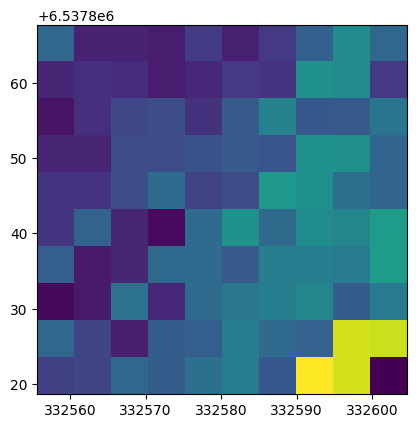

In [6]:
# Open the GeoTIFF file
with rasterio.open(path_test_tiff) as dataset:
    # Read the data as a numpy array
    data_3D = dataset.read()

    # Print the data
    print(data_3D.shape)

    # Visualize the data
    show(dataset)

#### This Image Contains All 373 Bands And Its Not Very Informative. Let's Try Something More Faimilar - Red, Green, & Blue (RGB).

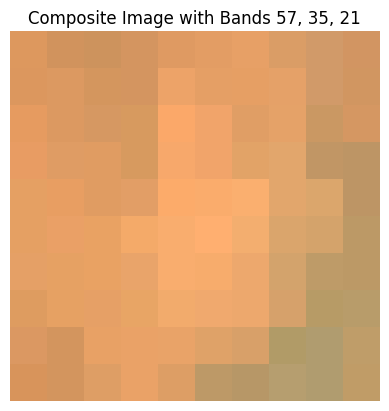

In [7]:
with rasterio.open(path_test_tiff) as dataset:
    # Read the bands as numpy arrays
    band_57 = dataset.read(57)  # Adjust with correct band number
    band_35 = dataset.read(35)  # Adjust with correct band number
    band_21 = dataset.read(21)  # Adjust with correct band number

    # Stack the bands to form a 3-channel (RGB) image
    rgb_image = np.stack([band_57, band_35, band_21], axis=-1)
    # Normalize the values (optional, depending on the image data scale)
    rgb_image = rgb_image / np.max(rgb_image)  # Normalize to [0, 1]

    # Plot the image
    plt.imshow(rgb_image)
    plt.title("Composite Image with Bands 57, 35, 21")
    plt.axis('off')  # Turn off axis
    plt.show()

#### Now that we have an understanding of the data, we can begin work on the entire dataset.

## Implement Funcitions To Unpack Data

In [8]:
def tiff_to_arr(filepath):
  '''
  Description:
    This function takes a filepath to a .tiff file, opens it, and reads it as a
    numpy arr. Then returns said array.
  Input:
    filepath  : The file path to the .tiff file, starting from /content/...
  Output:
    data_3D   : A 3 dimensional array of frequency bands for the pixels of an
                image.
  '''
  with rasterio.open(filepath) as dataset:
      # Read the data as a numpy array
      data_3D = dataset.read()
  return data_3D

In [9]:
def get_filenames(directory_path):
    '''
     * Description:
     *   gets the name of both files and directories at path_samples
     *   sorted by the first numeric prefix in the filename
     * Input(s):
     *   directory_path: the path to the directory containing sample files
     * Output(s):
     *   Sorted Numpy Array of Filenames, array of strings
    '''
    filenames = []
    for f in listdir(directory_path):
        # Ignore hidden files and directories (like .DS_Store)
        if f.startswith(".") or not isfile(join(directory_path, f)):
            continue

        try:
            # Try to parse the first part of the filename as an integer
            int(f.split("_")[0])
            filenames.append(f)  # Only add to the list if parsing succeeds
        except ValueError:
            print(f"Non-numeric prefix found in filename: {f}")  # Print any problematic filename

    # Sort the valid filenames and convert to a numpy array
    return np.array(sorted(filenames, key=lambda x: int(x.split("_")[0])))

## PCA

#### Given that we have 373 bands per image, this data can be hard to work with. To remedy this, we can use Principal Component Analysis (PCA). With PCA, Only the bands, or frequencies, with the most significant variance will been kept - the rest discarded

##### **Note:** From this point forward, the terms "band" and "frequency" will be used interchangeably as they represent the same thing.

## Setup Functions For DataFrame Generation, Data Manipulation, etc.

In [10]:
def pca_make_pandas_dataframe(dir_path, filename, col_labels):
    ds = tiff_to_arr(join(dir_path, filename))  # shape is (373, 10, 10)

    # Reshape to have each pixel position with 373 band values as a row
    reshaped_ds = ds.reshape(ds.shape[0], -1).T  # Shape becomes (100, 373) or (121, 373) depending on the data
    print(f"reshaped_ds shape: {reshaped_ds.shape}")  # Check shape of reshaped_ds

    # Create the DataFrame with band columns
    df = pd.DataFrame(reshaped_ds, columns=col_labels[:reshaped_ds.shape[1]])

    # Dynamically generate X and Y coordinates based on the number of rows in reshaped_ds
    num_rows = reshaped_ds.shape[0]
    x_vals = np.tile(np.arange(10), num_rows // 10)
    y_vals = np.repeat(np.arange(10), num_rows // 10)

    # Adjust lengths in case of rounding issues
    if len(x_vals) != num_rows:
        x_vals = np.resize(x_vals, num_rows)
    if len(y_vals) != num_rows:
        y_vals = np.resize(y_vals, num_rows)

    # Check if lengths match
    print(f"Length of X: {len(x_vals)}, Length of Y: {len(y_vals)}, Num Rows: {num_rows}")

    df['X'] = x_vals  # X coordinates
    df['Y'] = y_vals  # Y coordinates

    # Add filename for tracking
    df['File'] = filename

    return df

In [11]:
def pca_get_all_data(sample_directory_path):
  #Creates the frequency labels
  columns_of_frequencies = []
  for i in range(0,373,1):
    columns_of_frequencies.append("frq" + str(i))

  # get an array of the sample file names
  filenames = get_filenames(sample_directory_path)

  ## This is where we would trim the filenames for the ones we want

  #loop through and add to pandas dataframe
  list_df = []
  for i in range(0, len(filenames)):
    list_df.append(pca_make_pandas_dataframe(sample_directory_path, filenames[i], columns_of_frequencies))
    #print(i)

  return pd.concat(list_df)

In [12]:
df = pca_get_all_data(path_samples)

reshaped_ds shape: (100, 373)
Length of X: 100, Length of Y: 100, Num Rows: 100
reshaped_ds shape: (100, 373)
Length of X: 100, Length of Y: 100, Num Rows: 100
reshaped_ds shape: (121, 373)
Length of X: 121, Length of Y: 121, Num Rows: 121
reshaped_ds shape: (121, 373)
Length of X: 121, Length of Y: 121, Num Rows: 121
reshaped_ds shape: (110, 373)
Length of X: 110, Length of Y: 110, Num Rows: 110
reshaped_ds shape: (121, 373)
Length of X: 121, Length of Y: 121, Num Rows: 121
reshaped_ds shape: (110, 373)
Length of X: 110, Length of Y: 110, Num Rows: 110
reshaped_ds shape: (110, 373)
Length of X: 110, Length of Y: 110, Num Rows: 110
reshaped_ds shape: (110, 373)
Length of X: 110, Length of Y: 110, Num Rows: 110
reshaped_ds shape: (144, 373)
Length of X: 144, Length of Y: 144, Num Rows: 144
reshaped_ds shape: (132, 373)
Length of X: 132, Length of Y: 132, Num Rows: 132
reshaped_ds shape: (110, 373)
Length of X: 110, Length of Y: 110, Num Rows: 110
reshaped_ds shape: (110, 373)
Length of 

### Visualizing the DataFrame

In [13]:
df

,frq0,frq1,frq2,frq3,frq4,frq5,frq6,frq7,frq8,frq9,...,frq366,frq367,frq368,frq369,frq370,frq371,frq372,X,Y,File
0,0.018910,0.025453,0.026801,0.029931,0.025996,0.030246,0.033545,0.035334,0.039591,0.044717,...,0.154068,0.154073,0.158080,0.160214,0.164343,0.173604,0.190160,0,0,1_ang20231028t101421_014_L2A_OE_main_27577724_...
1,0.013469,0.015442,0.018657,0.021459,0.028462,0.029567,0.035124,0.038447,0.039005,0.042359,...,0.143804,0.146481,0.146843,0.155816,0.159489,0.157601,0.169750,1,0,1_ang20231028t101421_014_L2A_OE_main_27577724_...
2,0.013482,0.013153,0.018295,0.021435,0.028463,0.031020,0.033894,0.037844,0.039349,0.043371,...,0.145602,0.146007,0.148808,0.149374,0.162757,0.157468,0.167964,2,0,1_ang20231028t101421_014_L2A_OE_main_27577724_...
3,0.013058,0.024265,0.024345,0.023020,0.027349,0.033271,0.032494,0.036257,0.040206,0.042641,...,0.149051,0.150941,0.147344,0.155273,0.154464,0.140058,0.165022,3,0,1_ang20231028t101421_014_L2A_OE_main_27577724_...
4,0.015231,0.024812,0.023221,0.024547,0.028005,0.033780,0.032661,0.035639,0.040920,0.043962,...,0.158802,0.157301,0.157921,0.164166,0.162148,0.151324,0.178857,4,0,1_ang20231028t101421_014_L2A_OE_main_27577724_...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,0.110040,0.113846,0.122912,0.129257,0.133967,0.136724,0.142878,0.143184,0.149973,0.154388,...,0.077318,0.082198,0.073062,0.078871,0.106960,0.102698,0.037319,9,9,12128_ang20231031t091505_002_L2A_OE_main_27577...
60,0.090576,0.097904,0.101751,0.106854,0.110958,0.114553,0.118870,0.120013,0.125182,0.128634,...,0.048856,0.052119,0.038128,0.048034,0.072314,0.085504,0.048451,0,0,12128_ang20231031t091505_002_L2A_OE_main_27577...
61,0.109015,0.110967,0.114204,0.122206,0.125042,0.129206,0.131949,0.135035,0.139115,0.144689,...,0.063514,0.068835,0.070935,0.068684,0.062232,0.069433,0.070832,1,0,12128_ang20231031t091505_002_L2A_OE_main_27577...
62,0.127796,0.130344,0.136902,0.146922,0.151861,0.154839,0.158604,0.158993,0.164166,0.167904,...,0.088122,0.088683,0.088928,0.091659,0.105230,0.131382,0.131696,2,0,12128_ang20231031t091505_002_L2A_OE_main_27577...


##### Again, as we can see from the above dataframe, prior to PCA being performed, each pixel has 373 frequencies.

### Reshape and Manipulate Data For PCA

##### The dataframe is not currently compatible with PCA. Let's remove nonumeric columns, remove NaNs, etc.

In [14]:
# Drop non-numeric columns like 'X', 'Y', and 'File'
features = df.drop(columns=['X', 'Y', 'File'])

# Standardize the data (if features have different scales)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Convert the NumPy array to a pandas DataFrame and preserve the original index
features_scaled_df = pd.DataFrame(features_scaled, index=df.index)

# Replace NaN values with 0 instead of dropping rows
features_scaled_filled = features_scaled_df.fillna(0)

# Verify the row count of features_scaled_filled and df
print(f"features_scaled_filled rows: {len(features_scaled_filled)}")
print(f"Original df rows: {len(df)}")

features_scaled_filled rows: 415959
Original df rows: 415959


In [15]:
# Initialize PCA and reduce to 2 principal components
pca = PCA(n_components=2)  # Adjust the number of components if needed
principal_components = pca.fit_transform(features_scaled_filled)

# Create a DataFrame for the PCA results
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Check the index length after dropping NaNs
print(f"pca_df rows: {len(pca_df)}")

# Reset the index of df if it has a custom index
df_reset = df.reset_index(drop=True)

# Align the rows of df with the rows that remain in features_scaled_dropped
pca_df['X'] = df_reset.loc[features_scaled_filled.index, 'X'].values
pca_df['Y'] = df_reset.loc[features_scaled_filled.index, 'Y'].values
pca_df['File'] = df_reset.loc[features_scaled_filled.index, 'File'].values

pca_df rows: 415959


In [16]:
# Show the first few rows of the PCA result
print(pca_df.head())

        PC1       PC2  X  Y                                               File
0  4.059567 -6.072722  0  0  1_ang20231028t101421_014_L2A_OE_main_27577724_...
1  2.154698 -6.107913  1  0  1_ang20231028t101421_014_L2A_OE_main_27577724_...
2  1.647049 -6.058152  2  0  1_ang20231028t101421_014_L2A_OE_main_27577724_...
3  2.442465 -6.234372  3  0  1_ang20231028t101421_014_L2A_OE_main_27577724_...
4  4.533383 -6.185866  4  0  1_ang20231028t101421_014_L2A_OE_main_27577724_...


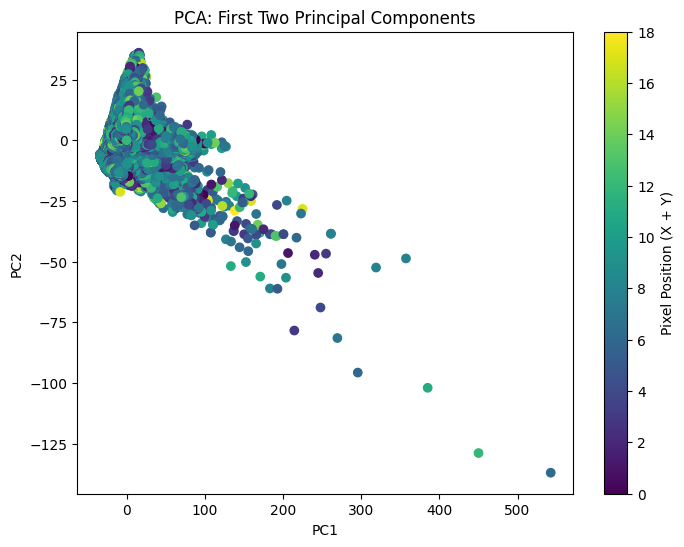

Explained variance ratio for each component: [0.7517341  0.14358875]


In [17]:
# Visualize the first two principal components
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['X'] + pca_df['Y'], cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA: First Two Principal Components')
plt.colorbar(label='Pixel Position (X + Y)')
plt.show()

# Explained variance ratio
print(f'Explained variance ratio for each component: {pca.explained_variance_ratio_}')

#### Here is an example of the result to PCA with two components. We can see that the first two components contain nearly 90% of the variance! We'd like a little more - let's keep trying.

### Plotting PCA Components

##### Let's plot a graph that will show us the necessary number of components for a specific amount of variance.

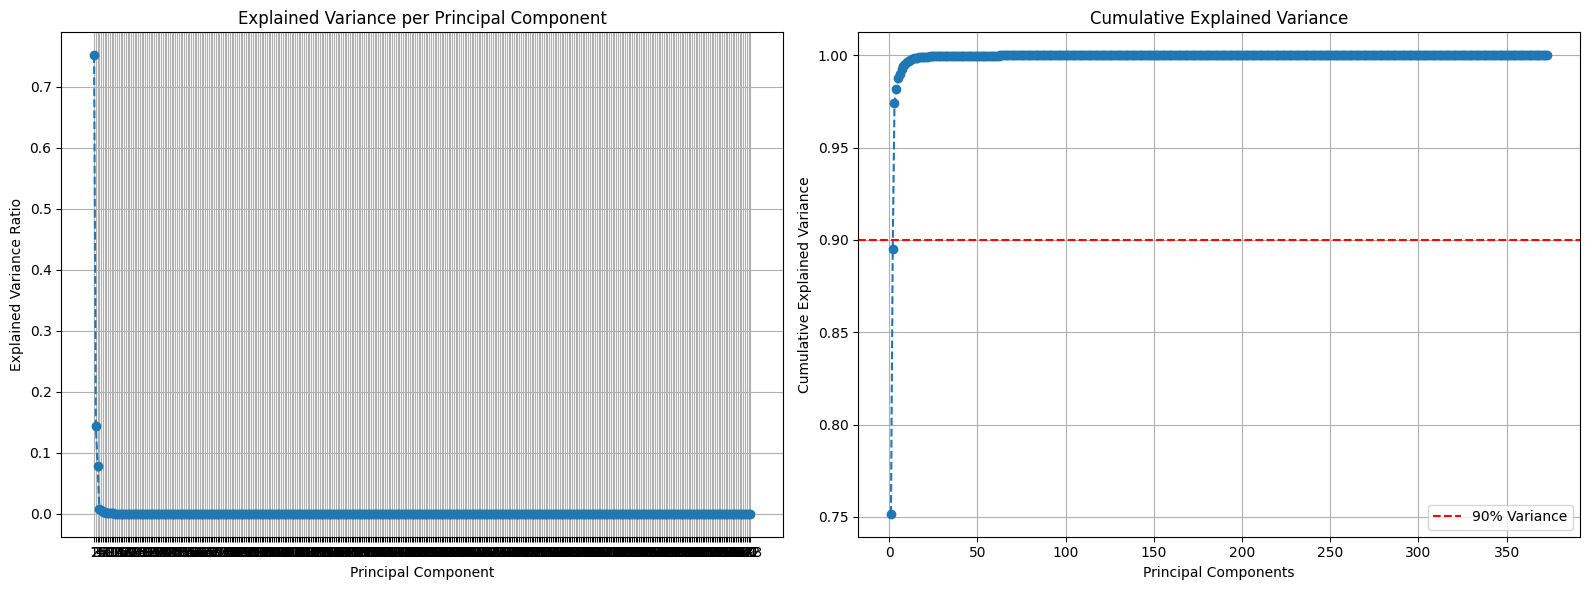

In [18]:
# Assuming features_scaled_dropped is your pre-processed data
pca_full = PCA()
principal_components_full = pca_full.fit_transform(features_scaled_filled)
explained_variance_ratio_full = pca_full.explained_variance_ratio_

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(explained_variance_ratio_full)

# Create a 1x2 subplot (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # Adjust the figsize as needed

# Plot the explained variance ratio for all components
axes[0].plot(range(1, len(explained_variance_ratio_full) + 1), explained_variance_ratio_full, marker='o', linestyle='--')
axes[0].set_title('Explained Variance per Principal Component')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_xticks(range(1, len(explained_variance_ratio_full) + 1))
axes[0].grid(True)

# Plot the cumulative explained variance
axes[1].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
axes[1].axhline(y=0.90, color='r', linestyle='--', label="90% Variance")
axes[1].set_title('Cumulative Explained Variance')
axes[1].set_xlabel('Principal Components')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].legend()
axes[1].grid(True)

# Show the plots
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

##### It looks like we'll need to use three principal components in order to achieve 90%+ variance. Let's try this agian.

In [19]:
# Determine the number of components to explain 90% of the variance
pca = PCA(n_components=0.90)  # Keep enough components to explain 90% variance
principal_components = pca.fit_transform(features_scaled_filled)
explained_variance_ratio = pca.explained_variance_ratio_

print(f"Number of components to explain 90% variance: {pca.n_components_}")

Number of components to explain 90% variance: 3


In [20]:
# Access the component loadings (how much each feature contributes to each component)
component_loadings = pca.components_

# Convert it to a DataFrame for easier inspection
loadings_df = pd.DataFrame(component_loadings, columns=features.columns)

# For each component, get the top 6 features with the highest absolute loadings
top_n = pca.n_components_
top_features = {}

for i in range(loadings_df.shape[0]):  # Loop through each component
    # Sort the values by absolute magnitude and get the top 6
    sorted_loadings = loadings_df.iloc[i].abs().sort_values(ascending=False).head(top_n)
    top_features[f"Component {i+1}"] = sorted_loadings

# Convert the result to a DataFrame for better presentation
top_features_df = pd.DataFrame(top_features)

# Print the top 6 features for each component
print(top_features_df)

        Component 1  Component 2  Component 3
frq100          NaN     0.086242          NaN
frq102          NaN     0.086200          NaN
frq253     0.058133          NaN          NaN
frq254     0.058138          NaN          NaN
frq255     0.058146          NaN          NaN
frq3            NaN          NaN     0.128541
frq4            NaN          NaN     0.128608
frq5            NaN          NaN     0.128622
frq99           NaN     0.086271          NaN


In [21]:
# Create a set to store the distinct frequencies used in the top features
used_frequencies = set()

# Loop through each component and add the top N frequencies to the set
for i in range(loadings_df.shape[0]):  # Loop through each component
    # Get the top features for the component by sorting by absolute magnitude
    sorted_loadings = loadings_df.iloc[i].abs().sort_values(ascending=False).head(top_n)
    # Add the indices (frequencies) of these top features to the set
    used_frequencies.update(sorted_loadings.index)

# Count the total number of unique frequencies used
total_used_frequencies = len(used_frequencies)

# Print the total number of unique frequencies
print(f"Total number of frequencies used across all components: {total_used_frequencies}")

# Print the names of the features (frequencies) used
print("\nFrequencies used across all components:")
for feature in used_frequencies:
    print(feature)

Total number of frequencies used across all components: 9

Frequencies used across all components:
frq255
frq5
frq3
frq99
frq102
frq254
frq253
frq4
frq100


### Add Principal Components To Data

##### Let's create a new dataframe that uses the three princiapl components, rather the 373 bands.

In [22]:
def add_principal_components(pca, principal_components, numComponents):
    # Convert the principal components to a DataFrame
    principal_components_df = pd.DataFrame(
        principal_components,
        columns=[f'PC{i+1}' for i in range(numComponents)]
    )

    # Reset the index for consistency
    principal_components_df = principal_components_df.reset_index(drop=True)

    # Reset index in df to align with features_scaled_dropped
    df_reset = df.reset_index(drop=True)

    # Select 'X', 'Y', and 'File' columns from df
    xy_file_df = df_reset[['X', 'Y', 'File']].iloc[:len(principal_components_df)].reset_index(drop=True)

    # Concatenate the selected columns with the principal components
    return pd.concat([xy_file_df, principal_components_df], axis=1)

##### Let's visualize the dataframe. We should see that each pixel contains 3 principal components and no additional frequencies.

In [23]:
data_with_pcs = add_principal_components(pca, principal_components, 3)
# Print the first 100 rows of the new dataset to verify
print(data_with_pcs.head())

   X  Y                                               File       PC1  \
0  0  0  1_ang20231028t101421_014_L2A_OE_main_27577724_...  4.059567   
1  1  0  1_ang20231028t101421_014_L2A_OE_main_27577724_...  2.154698   
2  2  0  1_ang20231028t101421_014_L2A_OE_main_27577724_...  1.647049   
3  3  0  1_ang20231028t101421_014_L2A_OE_main_27577724_...  2.442465   
4  4  0  1_ang20231028t101421_014_L2A_OE_main_27577724_...  4.533383   

        PC2       PC3  
0 -6.072722  0.702674  
1 -6.107913  0.824778  
2 -6.058152  0.914244  
3 -6.234372  0.884735  
4 -6.185866  0.665054  


### Visualizing an image

##### Re-assemble the image

In [24]:
# Step 1: Extract the first 100 pixels, each with 3 components
# Assuming data_with_pcs is a DataFrame with columns PC1, PC2, PC3 for each pixel
first_100_pixels = data_with_pcs[['PC1', 'PC2', 'PC3']].iloc[:100].values  # First 100 pixels with 3 components each

# Step 2: Reshape the data to 10x10x3 (image_dim x image_dim x 3 components per pixel)
image_dim = 10  # 10x10 image
reconstructed_image = first_100_pixels.reshape(image_dim, image_dim, 3)  # 3 components per pixel

# Step 3: Combine the 3 components into a single grayscale image (for simplicity)
combined_image = np.mean(reconstructed_image, axis=-1)  # Averaging the 3 components for grayscale



#### Now, let's view the first image in the dataset after PCA. We will compare it to the same image prior to PCA.

(373, 10, 10)


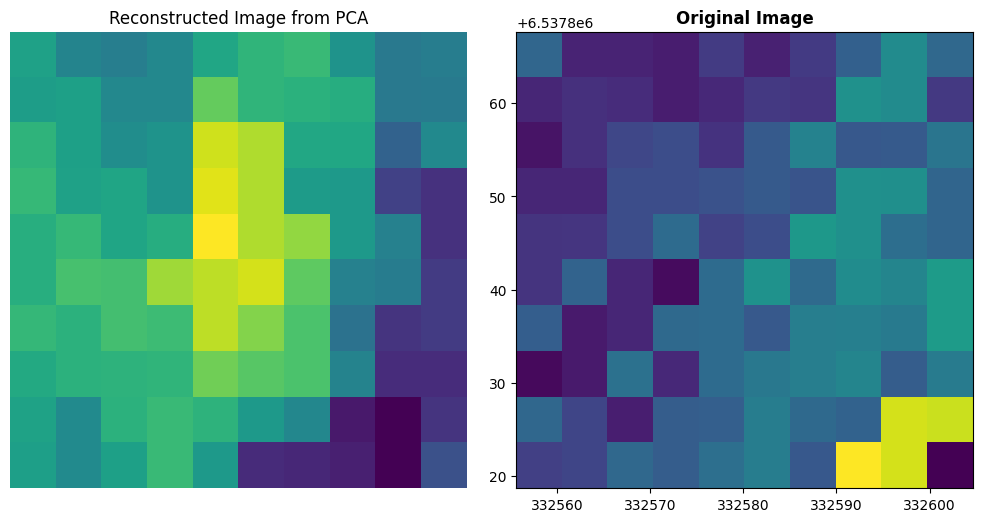

In [25]:
# Create a figure for the plots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns, adjust figure size

# Subplot 1: Reconstructed Image from PCA
axes[0].imshow(combined_image, aspect='equal')  # Maintain aspect ratio
axes[0].set_title('Reconstructed Image from PCA')
axes[0].axis('off')  # Remove axes for clean display

# Subplot 2: Rasterio Visualization
with rasterio.open(path_test_tiff) as dataset:
    data_3D = dataset.read()  # Read the data as a numpy array
    print(data_3D.shape)  # Print the shape of the 3D array

    # Visualize the data using Rasterio
    show(dataset, ax=axes[1], title='Original Image')

# Adjust layout for clarity
plt.tight_layout()
plt.show()

#### Success! From this, we can see that there are new identifiable features! Let's try another for good measure.

#### Using Components 2, 3, & 4

In [26]:
# Extract components 2, 3, and 4 (indexing starts at 0, so these are columns 1, 2, and 3)
selected_components = principal_components_full[:, 1:4]

In [27]:
data_with_pcs2 = add_principal_components(pca_full, selected_components, 3)
# Print the first 100 rows of the new dataset to verify
print(data_with_pcs2.head())

   X  Y                                               File       PC1  \
0  0  0  1_ang20231028t101421_014_L2A_OE_main_27577724_... -6.072722   
1  1  0  1_ang20231028t101421_014_L2A_OE_main_27577724_... -6.107913   
2  2  0  1_ang20231028t101421_014_L2A_OE_main_27577724_... -6.058152   
3  3  0  1_ang20231028t101421_014_L2A_OE_main_27577724_... -6.234372   
4  4  0  1_ang20231028t101421_014_L2A_OE_main_27577724_... -6.185866   

        PC2       PC3  
0  0.702674  1.255169  
1  0.824778  1.205117  
2  0.914244  1.256465  
3  0.884735  1.122120  
4  0.665054  1.180161  


##### **Note:** While the principal components are labeled PC1, PC2, PC3, these correspond to principal components 2, 3, & 4. Keeping them labeled this way allows for greater re-usability with our code.  

##### Re-assemble the image

In [28]:
# Step 1: Extract the first 100 pixels, each with 3 components
# Assuming data_with_pcs is a DataFrame with columns PC1, PC2, PC3 for each pixel
first_100_pixels = data_with_pcs2[['PC1', 'PC2', 'PC3']].iloc[:100].values  # First 100 pixels with 3 components each

# Step 2: Reshape the data to 10x10x3 (image_dim x image_dim x 3 components per pixel)
reconstructed_image2 = first_100_pixels.reshape(image_dim, image_dim, 3)  # 3 components per pixel

# Step 3: Combine the 3 components into a single grayscale image (for simplicity)
combined_image2 = np.mean(reconstructed_image2, axis=-1)  # Averaging the 3 components for grayscale


### Let's visualize all three versions of the first image.

(373, 10, 10)


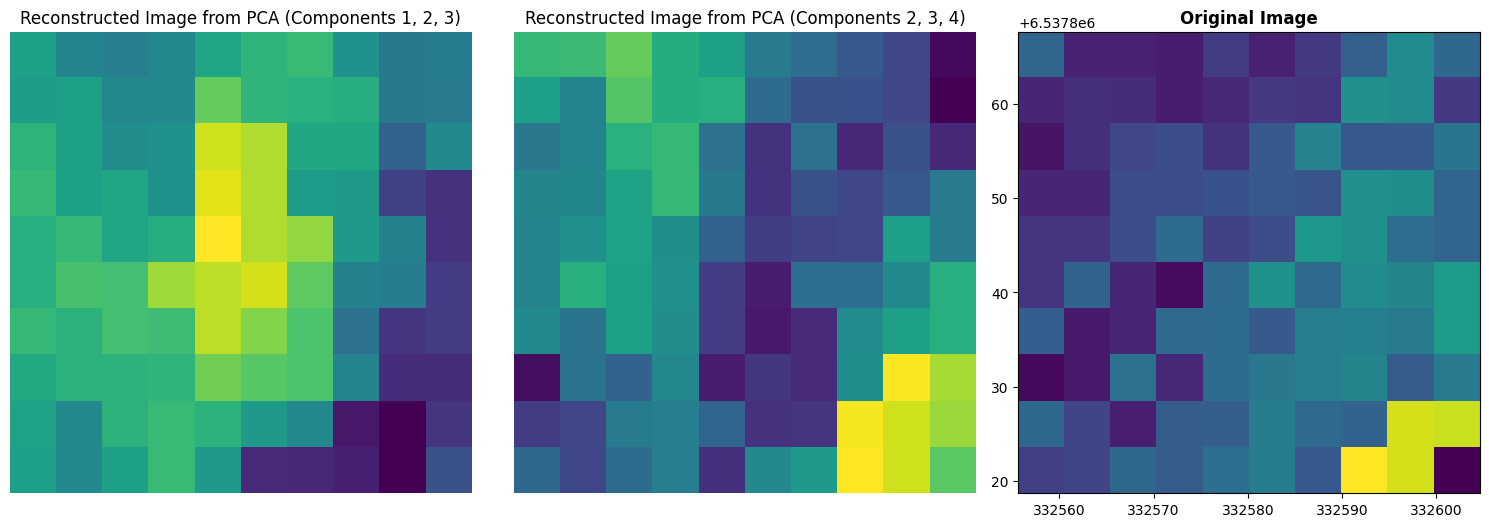

In [29]:
# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns, adjust figure size

# Subplot 1: Reconstructed Image from PCA (Components 1, 2, 3)
axes[0].imshow(combined_image, aspect='equal')  # Maintain aspect ratio
axes[0].set_title('Reconstructed Image from PCA (Components 1, 2, 3)')
axes[0].axis('off')  # Remove axes for clean display

# Subplot 2: Reconstructed Image from PCA (Components 2, 3, 4)
axes[1].imshow(combined_image2, aspect='equal')  # Maintain aspect ratio
axes[1].set_title('Reconstructed Image from PCA (Components 2, 3, 4)')
axes[1].axis('off')  # Remove axes for clean display

# Subplot 3: Rasterio Visualization
with rasterio.open(path_test_tiff) as dataset:
    data_3D = dataset.read()  # Read the data as a numpy array
    print(data_3D.shape)  # Print the shape of the 3D array

    # Visualize the data using Rasterio
    show(dataset, ax=axes[2], title='Original Image')

# Adjust layout for clarity
plt.tight_layout()
plt.show()

##### Another success! We can see that using principal components 1, 2, & 3 produced different results from that of princiapl components 2, 3, & 4. Which one will yield better results? It's time to train some conputer vision models, let's find out!

## Setup For Computer Vision Models

### Process Labels

In [30]:
# Load the Excel file
excel_file = 'Labels/CNN_Sample_Boxes_Subset_241018.xlsx'
#excel_file = '/content/drive/MyDrive/Landcover-Classification_11-17/CNN_Sample_Boxes_Subset_241018.xlsx'

# Read the Excel file into a DataFrame
df = pd.read_excel(excel_file, sheet_name=5)

# Display the first few rows
print(df.head())

# Access specific columns
image_numbers = df['Sample_num']
labels = df['Class']

# Access specific rows
first_row = df.iloc[0]  # First row as a Series
first_value = df.iloc[0, 0]  # First cell value

# Iterate over rows
#for index, row in df.iterrows():
   # print(f"Sample_num: {row['Sample_num']}, Label: {row['Class']}")


   Sample_num                                   Class Notes
0         1.0                   Unconsolidated Barren   NaN
1         2.0                   Unconsolidated Barren   NaN
2         3.0  Consolidated Barren (rocks, salt pans)   NaN
3         4.0                Annual Crops (e.g wheat)   NaN
4         5.0                Annual Crops (e.g wheat)   NaN


In [31]:
def assign_images_to_samples(image_folder, labels_excel, output_folder, sheet_index=5):
    """
    Assigns images to each Sample_num and Class pair from the DataFrame,
    matching the filenames exactly to the format Sample_num + "_".

    Args:
    - image_folder (str): Path to the folder containing the images.
    - labels_excel (str): Path to the Excel file containing Sample_num and Class labels.
    - output_folder (str): Path to the output folder where organized data will be saved.
    - sheet_index (int): Index of the sheet to read from the Excel file.

    Returns:
    - None
    """
    # Read the specified sheet from the Excel file
    df = pd.read_excel(labels_excel, sheet_name=sheet_index)

    # Convert Sample_num to integers, then to strings
    df['Sample_num'] = df['Sample_num'].apply(lambda x: str(int(x)) if not pd.isna(x) else None)

    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Iterate through the DataFrame
    for index, row in df.iterrows():
        sample_num = row['Sample_num']
        label = row['Class']

        if sample_num is None:
            print(f"Skipping row {index} with missing Sample_num")
            continue

        # Find the matching image in the image folder
        assigned_image = None
        for image_file in os.listdir(image_folder):
            # Match files that start with Sample_num followed by "_"
            if image_file.startswith(f"{sample_num}_") and image_file.lower().endswith(('.tif', '.jpg', '.jpeg', '.png')):
                assigned_image = image_file
                break

        # Check if an image was found
        if assigned_image:
            # Create a subdirectory for the label if it doesn't exist
            label_folder = os.path.join(output_folder, str(label))
            os.makedirs(label_folder, exist_ok=True)

            # Copy the image to the appropriate label folder
            source_path = os.path.join(image_folder, assigned_image)
            destination_path = os.path.join(label_folder, assigned_image)
            shutil.copy(source_path, destination_path)
        else:
            print(f"No image found for Sample_num {sample_num}")

    print(f"Images organized into {output_folder}.")


In [32]:
def get_labels_from_folder(organized_folder):
    """
    Extract labels and file paths from the organized folder.

    Args:

    organized_folder (str): Path to the folder with subfolders as class labels.

        Returns:

    filenames (list): List of file paths.
    labels (list): List of corresponding class labels."""
    filenames = []
    labels = []

    # Iterate through subfolders
    for label_folder in os.listdir(organized_folder):
        label_path = os.path.join(organized_folder, label_folder)
        if os.path.isdir(label_path):  # Ensure it's a directory
            for file in os.listdir(label_path):
                if file.lower().endswith(('.tif')):
                    filenames.append(os.path.join(label_path, file))
                    labels.append(label_folder)  # Use string label directly

    return filenames, labels

In [33]:
#organized_folder = "/content/drive/MyDrive/Landcover-Classification_11-17/Organized_Images"
organized_folder = "Organized_Images/"

#Get file paths and string labels
filepaths, string_labels = get_labels_from_folder(organized_folder)

#Encode string labels to integers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(string_labels)

#Ensure actual_labels matches the number of samples
print(f"Number of files: {len(filepaths)}, Number of labels: {len(string_labels)}")

#Print mapping of string labels to integers (optional)
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(f"Label mapping: {label_mapping}")

Number of files: 1620, Number of labels: 1620
Label mapping: {np.str_('Annual Crops (e.g wheat)'): np.int64(0), np.str_('Built-up'): np.int64(1), np.str_('Consolidated Barren (rocks, salt pans)'): np.int64(2), np.str_('Mixed or Not Classified'): np.int64(3), np.str_('Natural Grassland'): np.int64(4), np.str_('Natural Wooded Land'): np.int64(5), np.str_('Permanent Crops (e.g., vineyard)'): np.int64(6), np.str_('Planted Forest'): np.int64(7), np.str_('Shrubs'): np.int64(8), np.str_('Unconsolidated Barren'): np.int64(9), np.str_('Waterbodies'): np.int64(10), np.str_('Wetlands'): np.int64(11)}


### Label Frequency

In [34]:
# Count frequency of each label
label_counts = Counter(y)

# Map back to string labels for better interpretability
string_label_counts = {label_encoder.inverse_transform([k])[0]: v for k, v in label_counts.items()}

# Prepare data for the table
table_data = [(label, count) for label, count in string_label_counts.items()]
headers = ["Label", "Frequency"]

# Display as a table
print(tabulate(table_data, headers=headers, tablefmt="grid"))

+----------------------------------------+-------------+
| Label                                  |   Frequency |
+========================================+=============+
| Consolidated Barren (rocks, salt pans) |         119 |
+----------------------------------------+-------------+
| Wetlands                               |           5 |
+----------------------------------------+-------------+
| Permanent Crops (e.g., vineyard)       |          19 |
+----------------------------------------+-------------+
| Natural Grassland                      |         226 |
+----------------------------------------+-------------+
| Built-up                               |         107 |
+----------------------------------------+-------------+
| Annual Crops (e.g wheat)               |         148 |
+----------------------------------------+-------------+
| Natural Wooded Land                    |         232 |
+----------------------------------------+-------------+
| Waterbodies                  

In [35]:
# Track labels with less than 50 occurrences
infrequent_labels = {k: v for k, v in string_label_counts.items() if v < 50}

# Prepare data for the table
infrequent_labels = [(label, count) for label, count in infrequent_labels.items()]
headers = ["Label", "Frequency"]

# Display as a table
if infrequent_labels:
    print("\nLabels with fewer than 50 occurrences:")
    print(tabulate(infrequent_labels, headers=headers, tablefmt="grid"))
else:
    print("\nNo labels with fewer than 50 occurrences.")


Labels with fewer than 50 occurrences:
+----------------------------------+-------------+
| Label                            |   Frequency |
+==================================+=============+
| Wetlands                         |           5 |
+----------------------------------+-------------+
| Permanent Crops (e.g., vineyard) |          19 |
+----------------------------------+-------------+
| Planted Forest                   |          20 |
+----------------------------------+-------------+


In [36]:
def remove_infrequent_labels(X, y, min_frequency=50):
    """
    Remove or ignore rows from X and y with labels that occur less than min_frequency times.

    Parameters:
        X (numpy.ndarray): Input data array.
        y (numpy.ndarray): Label array.
        min_frequency (int): Minimum frequency for a label to be retained.

    Returns:
        X_filtered (numpy.ndarray): Filtered input data.
        y_filtered (numpy.ndarray): Filtered labels.
    """
    # Count label frequencies
    label_counts = Counter(y)

    # Identify labels with sufficient frequency
    valid_labels = {label for label, count in label_counts.items() if count >= min_frequency}

    # Filter X and y
    indices_to_keep = [i for i, label in enumerate(y) if label in valid_labels]
    X_filtered = X[indices_to_keep]
    y_filtered = y[indices_to_keep]

    return X_filtered, y_filtered


## Micro CNN

In [37]:
def confMat(model, x_test, y_test, class_names):
    """
    Plots a visual confusion matrix for a given model and test data.

    Args:

    model: Trained model to evaluate.
    x_test: Test features.
    y_test: True labels for test data.
    class_names: List of class names corresponding to numerical labels.
    """
    plt.figure(figsize=(15, 5))

    # Predict test images
    predict_x = model.predict(x_test)
    # Get corresponding predicted label
    y_pred = np.argmax(predict_x, axis=1)

    # Generate confusion matrix, ensuring all class labels are included
    cm = confusion_matrix(y_test, y_pred, labels=np.arange(len(class_names)))
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

    # Plot confusion matrix
    plt.title("Confusion Matrix")
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu", cbar=False)
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

In [38]:
def visualize_classification_results(model, X_test, y_test, label_encoder, category, num_samples=5):
    """
    Visualizes correctly and incorrectly classified images for a specific category without filepaths.

    Args:
    - model: Trained model for predictions.
    - X_test: Test image data.
    - y_test: Ground truth labels for test data.
    - label_encoder: Label encoder used to map labels.
    - category: The category to analyze (string).
    - num_samples: Number of correct and incorrect samples to display.

    Returns:
    - None (displays images with their classifications).
    """
    # Get the category's numeric label
    category_label = label_encoder.transform([category])[0]

    # Predict the labels for the test data
    y_pred = np.argmax(model.predict(X_test), axis=1)

    # Find indices of correct and incorrect predictions for the category
    correct_indices = [
        i for i in range(len(y_test))
        if y_test[i] == category_label and y_pred[i] == category_label
    ]
    incorrect_indices = [
        i for i in range(len(y_test))
        if y_test[i] == category_label and y_pred[i] != category_label
    ]

    # Ensure at least one incorrect image is displayed
    if not incorrect_indices:
        print(f"No incorrect classifications found for category: {category}")
        incorrect_indices = [i for i in range(len(y_test)) if y_pred[i] != y_test[i]]
        print(f"Using incorrect predictions from other categories instead.")
        # Optionally limit to the first `num_samples` incorrect indices
        incorrect_indices = incorrect_indices[:num_samples]

    # Plot correct classifications
    print(f"Correctly Classified Images for Category: {category}")
    for idx in correct_indices[:num_samples]:
        image = X_test[idx]
        plt.imshow(image.mean(axis=-1), cmap="viridis")  # Use mean of all channels for grayscale
        #plt.colorbar()
        plt.title(f"Correct: {category}")
        plt.xlabel("Mean of PC1, PC2, PC3")
        plt.axis('off')
        plt.show()

    # Plot incorrect classifications
    print(f"Incorrectly Classified Images for Category: {category}")
    for idx in incorrect_indices[:num_samples]:
        image = X_test[idx]
        predicted_label = label_encoder.inverse_transform([y_pred[idx]])[0]
        plt.imshow(image.mean(axis=-1), cmap="viridis")  # Use mean of all channels for grayscale
        #plt.colorbar()
        plt.title(f"Incorrect: {category} -> Predicted: {predicted_label}")
        plt.xlabel("Mean of PC1, PC2, PC3")
        plt.axis('off')
        plt.show()


In [39]:
def microCNN(data):
    # Step 1: Prepare the input and labels
    num_samples = len(data)
    #print(num_samples)


    # Extract the first three principal components as features
    X = data[['PC1', 'PC2', 'PC3']].values
    label_encoder = LabelEncoder()  # Initialize the LabelEncoder
    y = label_encoder.fit_transform(string_labels)  # Transform string labels to integers



    #print(f"Original shape of X: {X.shape}")
    #print(f"Total elements in X: {X.size}")


    # Determine number of valid samples
    num_samples = X.shape[0] // 100  # Each sample needs 10x10=100 rows

    # Truncate and reshape
    num_samples = len(y)
    X = X[:num_samples * 100]        # Truncate extra rows
    X = X.reshape(num_samples, 10, 10, 3)  # Reshape to (num_samples, 10, 10, 3)

    # Adjust labels
    y = y[:num_samples]

    #print(f"New shape of X: {X.shape}")  # Should be (num_samples, 10, 10, 3)
    #print(f"New length of y: {len(y)}")

    # Proceed with train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y[:num_samples], test_size=0.2, random_state=42, stratify=y,)

    # Remove data with labels with frequency < 50
    '''
    X_filtered, y_filtered = remove_infrequent_labels(X, y, min_frequency=50)

    # Proceed with train-test split on the filtered data
    X_train, X_test, y_train, y_test = train_test_split(
        X_filtered, y_filtered, test_size=0.2, random_state=42, stratify=y_filtered
    )
    '''

    # Step 2: Define a simple CNN
    model = models.Sequential([
        layers.Input(shape=(10, 10, 3)),  # Define input shape explicitly
        layers.Conv2D(16, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_samples, activation='softmax')  # Adjust the output layer for the number of classes
    ])

    # Compile the model
    model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

    # Step 3: Train the model ###This method might take longer to run but provides a high accuracy
    kf = KFold(n_splits=5)
    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50)



    print("\n")
    # Step 4: Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

    print("\n")
    # Step 5: Use the model to predict
    predictions = model.predict(X_test)
    print(f"Predictions: {np.argmax(predictions, axis=1)[:10]}")

    y_pred = np.argmax(model.predict(X_test), axis=1)
    #print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))


    # Only Display Labels With Frequency > 50
    '''
    # Extract just the label names (from infrequent_labels)
    infrequent_labels_set = {label for label, _ in infrequent_labels}

    # Remove infrequent labels from label_encoder.classes_
    class_names = [class_name for class_name in label_encoder.classes_ if class_name not in infrequent_labels_set]

    # Print the result
    print(f"Class Names: {class_names}")
    '''

    #Retrieve class names from the label encoder
    class_names = label_encoder.classes_

    confMat(model, X_test, y_test,class_names)

    visualize_classification_results(
    model=model,                 # Your trained model
    X_test=X_test,               # Test images
    y_test=y_test,               # Ground truth labels
    label_encoder=label_encoder, # LabelEncoder instance
    category="Natural Wooded Land",  # Category to visualize
    num_samples=5                # Number of images to show
)



    return history

Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1976 - loss: 5.0978 - val_accuracy: 0.3364 - val_loss: 3.8157
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3930 - loss: 1.8781 - val_accuracy: 0.3519 - val_loss: 3.8524
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4223 - loss: 1.7377 - val_accuracy: 0.3488 - val_loss: 3.8208
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4513 - loss: 1.6319 - val_accuracy: 0.3488 - val_loss: 3.8124
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4458 - loss: 1.6362 - val_accuracy: 0.3519 - val_loss: 4.1124
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4406 - loss: 1.5646 - val_accuracy: 0.3519 - val_loss: 4.3100
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4785 - loss: 1.5098 - val_accuracy: 0.3642 - val_loss: 3.6736
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4929 - loss: 1.4745 - val_accuracy: 0.3951 - val_loss:

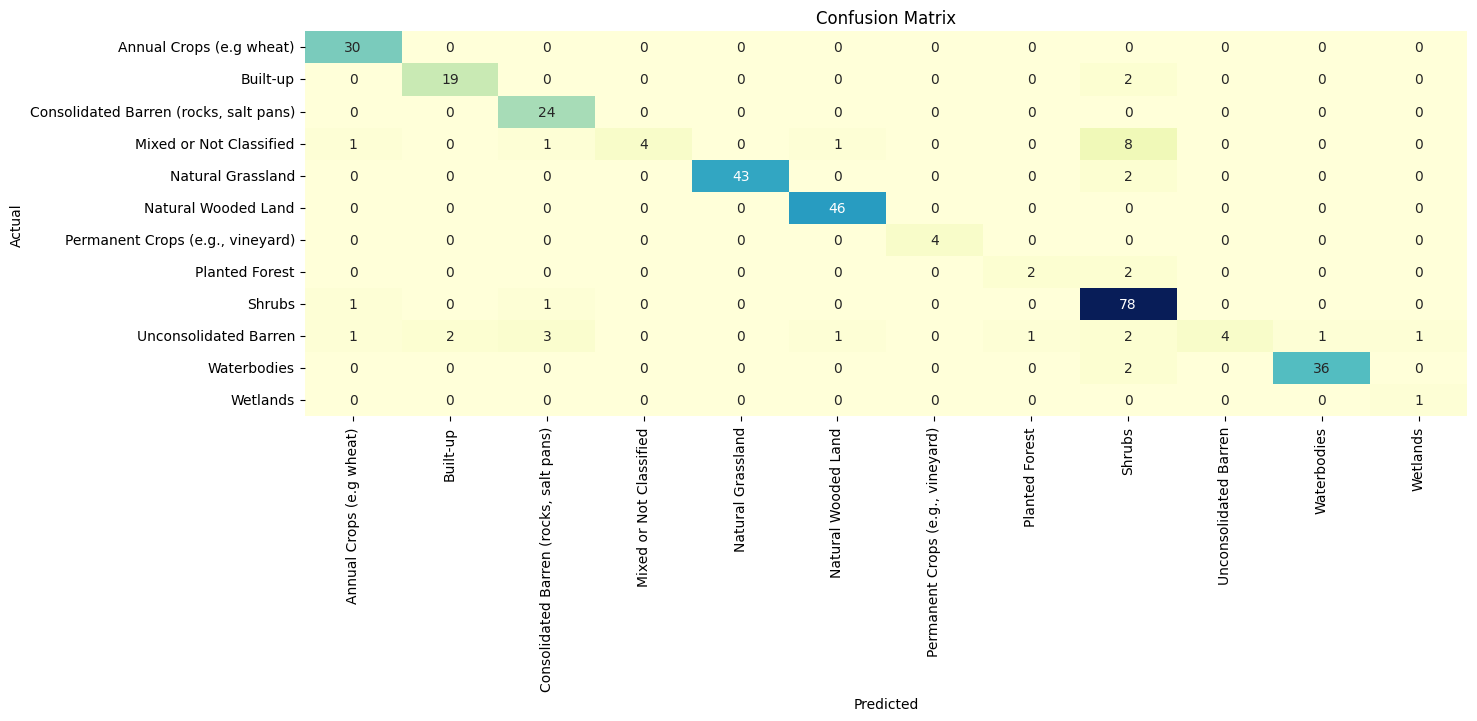

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
No incorrect classifications found for category: Natural Wooded Land
Using incorrect predictions from other categories instead.
Correctly Classified Images for Category: Natural Wooded Land


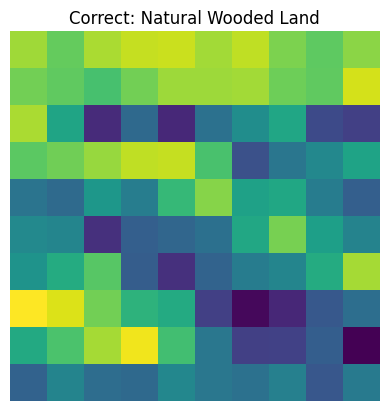

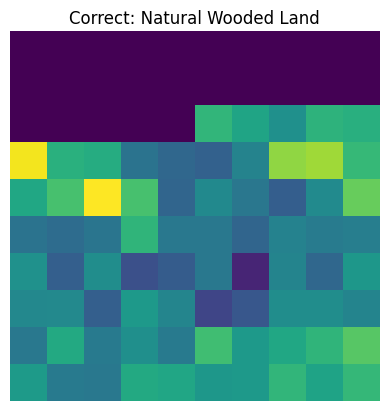

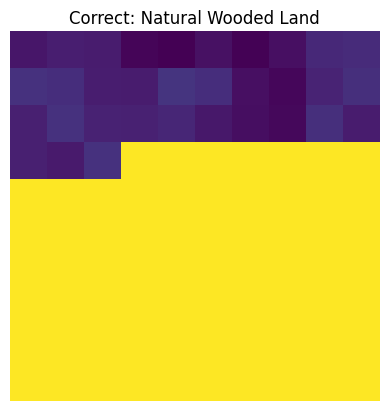

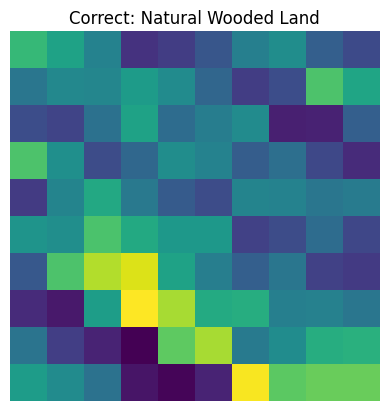

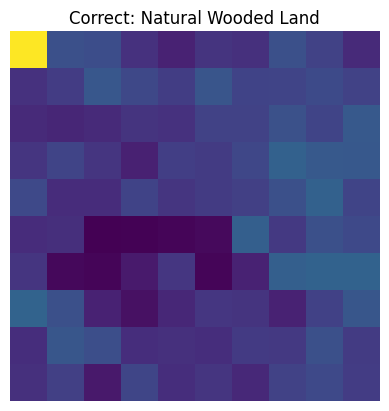

Incorrectly Classified Images for Category: Natural Wooded Land


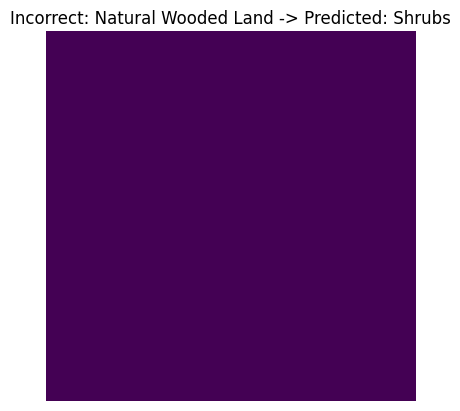

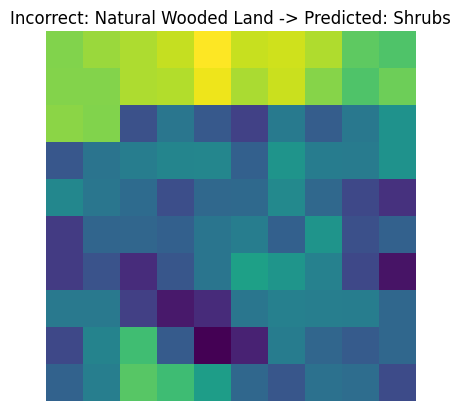

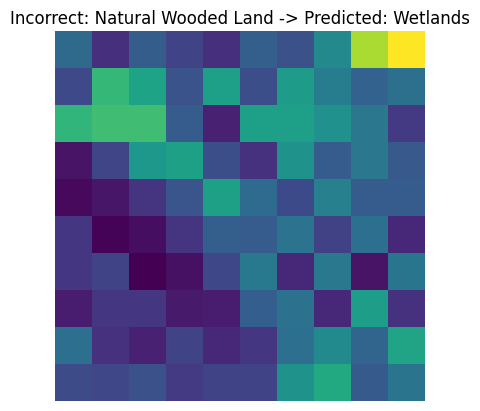

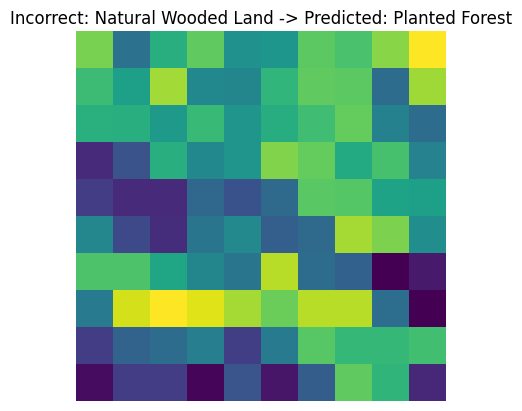

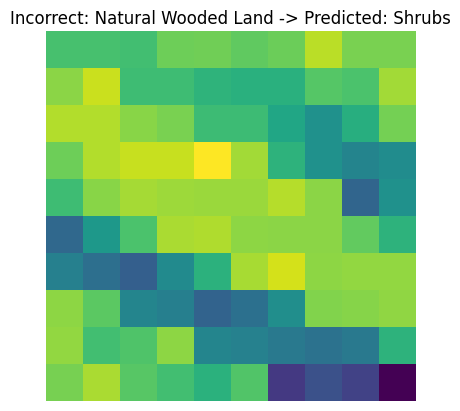

In [40]:
pca_history1 = microCNN(data_with_pcs)

Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1869 - loss: 5.8327 - val_accuracy: 0.3056 - val_loss: 4.0278
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3556 - loss: 1.9379 - val_accuracy: 0.2870 - val_loss: 4.0918
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4098 - loss: 1.8167 - val_accuracy: 0.3210 - val_loss: 4.1938
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3788 - loss: 1.7680 - val_accuracy: 0.3457 - val_loss: 4.1165
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4058 - loss: 1.7401 - val_accuracy: 0.3488 - val_loss: 4.3200
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4388 - loss: 1.6600 - val_accuracy: 0.3302 - val_loss: 4.4265
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4355 - loss: 1.6498 - val_accuracy: 0.3457 - val_loss: 4.1554
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4691 - loss: 1.5678 - val_accuracy: 0.3796 - val_loss:

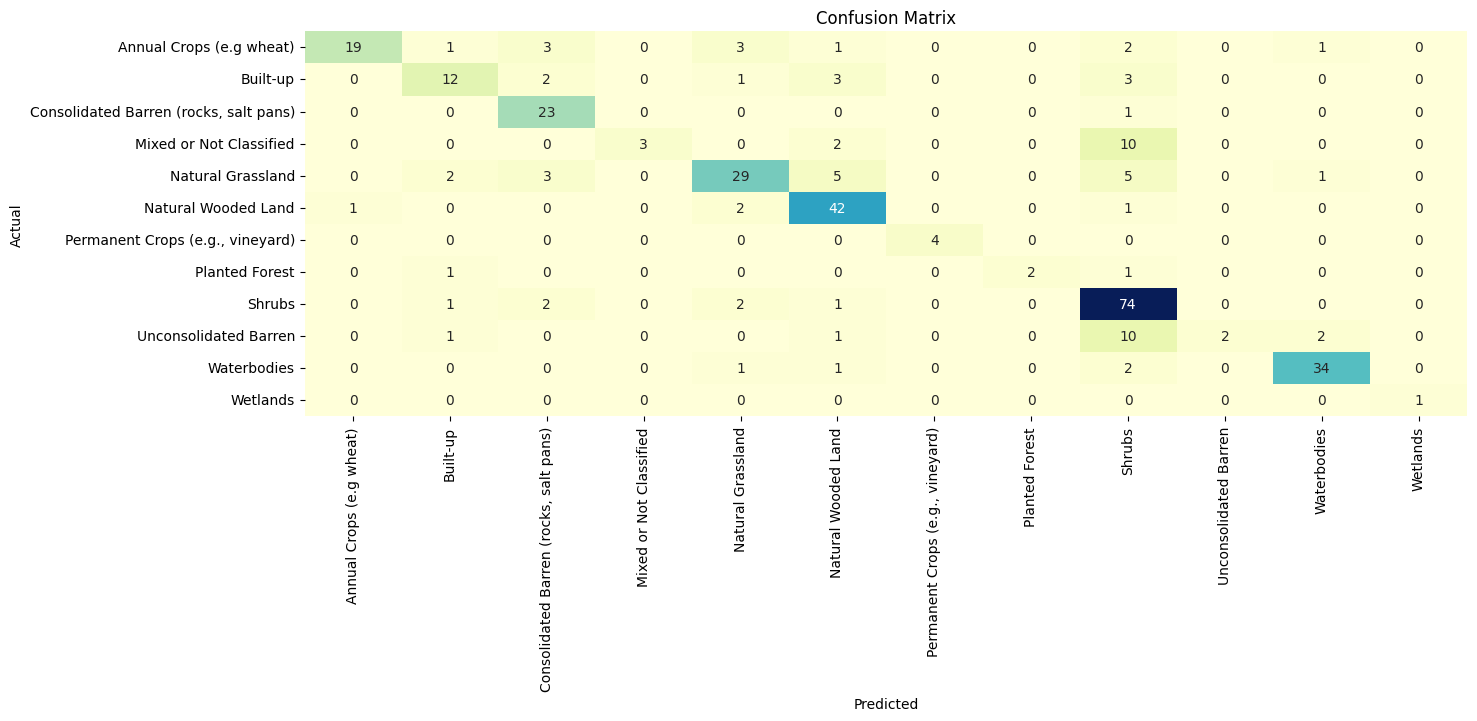

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
Correctly Classified Images for Category: Natural Wooded Land


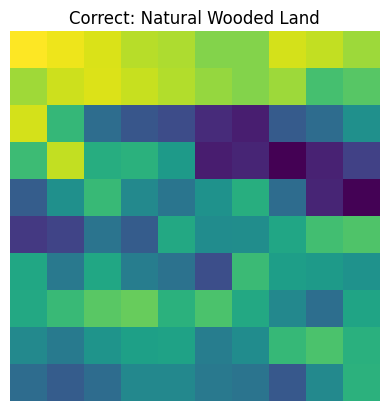

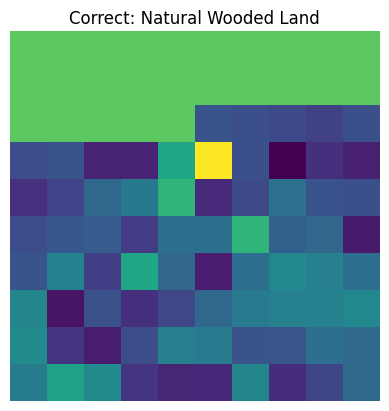

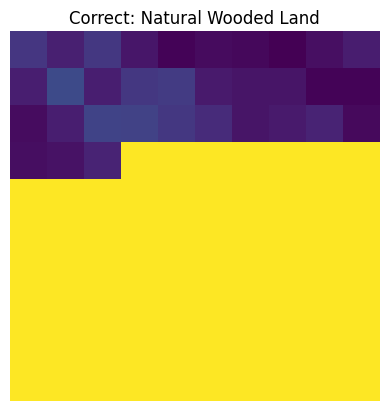

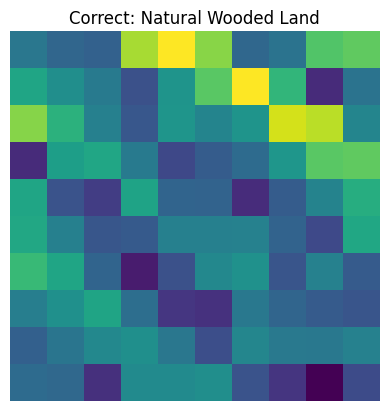

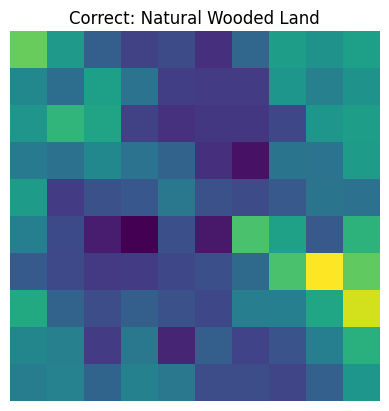

Incorrectly Classified Images for Category: Natural Wooded Land


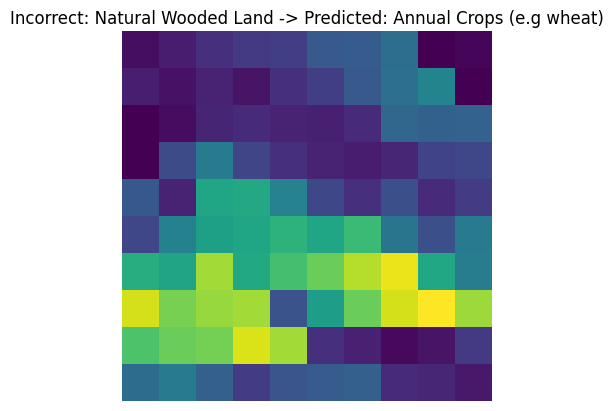

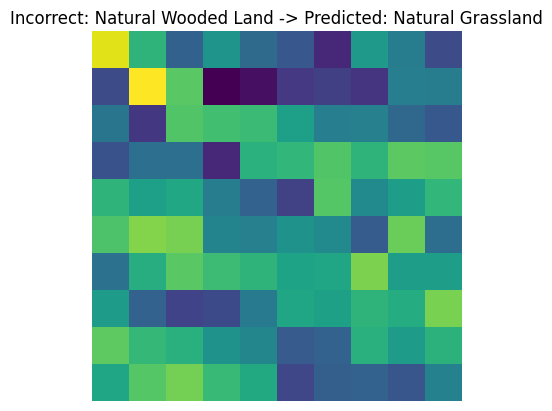

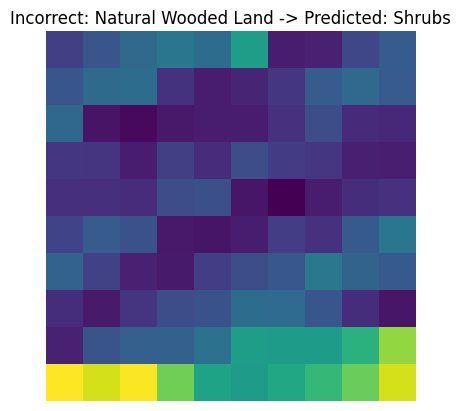

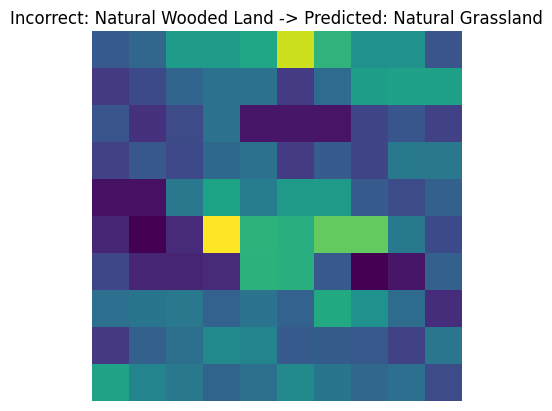

In [41]:
pca_history2 = microCNN(data_with_pcs2)

In [42]:
best_val_accuracy = max(pca_history1.history['val_accuracy'])
print(f"Best validation accuracy with principal components 1, 2, & 3: {best_val_accuracy}")

Best validation accuracy with principal components 1, 2, & 3: 0.9074074029922485


In [43]:
best_val_accuracy2 = max(pca_history2.history['val_accuracy'])
print(f"Best validation accuracy with principal components 2, 3, & 4: {best_val_accuracy2}")

Best validation accuracy with principal components 2, 3, & 4: 0.9567901492118835


### Wow! The model perfomred well with both sets of components. However it seems like components 2, 3, and 4 are performing exceptionally well. Going forward, when we want to use the result of PCA, we'll use components 2, 3, & 4.

## MacroCNN

In [44]:
def macroCNN(data):
    # Step 1: Prepare the input and labels
    num_samples = len(data)

    # Extract the first three principal components as features
    X = data[['PC1', 'PC2', 'PC3']].values
    y = LabelEncoder().fit_transform(string_labels)  # Encode labels if they are categorical

    # Determine number of valid samples
    num_samples = X.shape[0] // 100  # Each sample needs 10x10=100 rows

    # Truncate and reshape
    num_samples = len(y)
    X = X[:num_samples * 100]        # Truncate extra rows
    X = X.reshape(num_samples, 10, 10, 3)  # Reshape to (num_samples, 10, 10, 3)

    # Adjust labels
    y = y[:num_samples]

    # Proceed with train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y[:num_samples], test_size=0.2, random_state=42, stratify=y)

    # Step 2: Define a more complex CNN
    model = models.Sequential([
        layers.Input(shape=(10, 10, 3)),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_samples, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Step 3: Define ModelCheckpoint to save the best model based on validation accuracy
    checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

    # Step 4: Train the model with the ModelCheckpoint callback
    kf = KFold(n_splits=5)
    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        macro_history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[checkpoint])

    print("\n")
    # Step 5: Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

    print("\n")
    # Step 6: Use the model to predict
    predictions = model.predict(X_test)
    print(f"Predictions: {np.argmax(predictions, axis=1)[:10]}")

    y_pred = np.argmax(model.predict(X_test), axis=1)
    print(classification_report(y_test, y_pred))

    # Retrieve class names from the label encoder
    class_names = label_encoder.classes_
    best_model = load_model('best_model.keras')
    confMat(best_model, X_test, y_test, class_names)

    visualize_classification_results(
    model=best_model,                 # Your trained model
    X_test=X_test,               # Test images
    y_test=y_test,               # Ground truth labels
    label_encoder=label_encoder, # LabelEncoder instance
    category="Natural Wooded Land",  # Category to visualize
    num_samples=5                # Number of images to show
    )

    return macro_history

Epoch 1/100
35/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1558 - loss: 5.0083 
Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to best_model.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1622 - loss: 4.7494 - val_accuracy: 0.0000e+00 - val_loss: 8.7503
Epoch 2/100
38/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2603 - loss: 2.1599
Epoch 2: val_accuracy did not improve from 0.00000
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2630 - loss: 2.1514 - val_accuracy: 0.0000e+00 - val_loss: 10.0779
Epoch 3/100
36/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3435 - loss: 1.9150
Epoch 3: val_accuracy did not improve from 0.00000
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3423 - loss: 1.9115 - val_accuracy: 0.0000e+00 - val_loss: 9.0303
Epoch 4/100
37/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3261 - loss: 1.8016
Epoch 4: val_accuracy did not improve from 0.00000
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3287 - lo

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


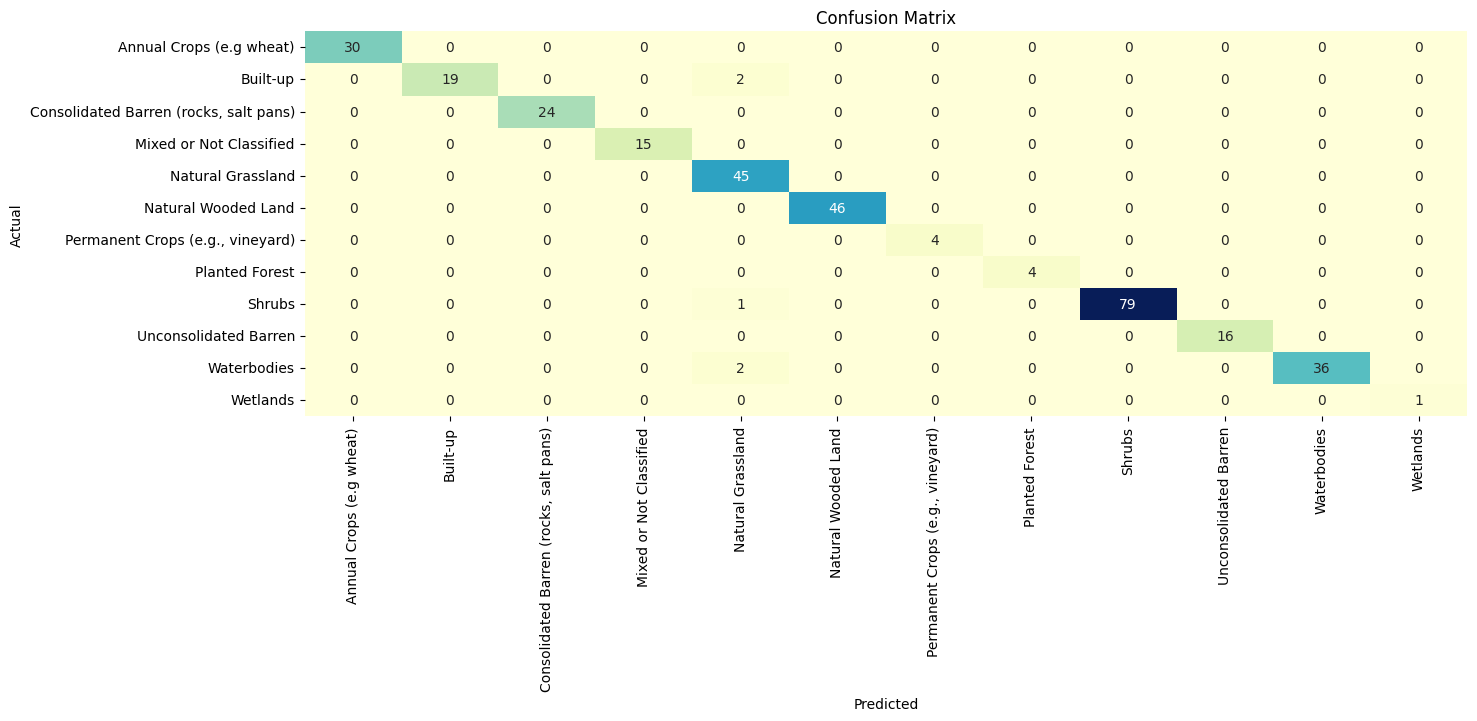

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
No incorrect classifications found for category: Natural Wooded Land
Using incorrect predictions from other categories instead.
Correctly Classified Images for Category: Natural Wooded Land


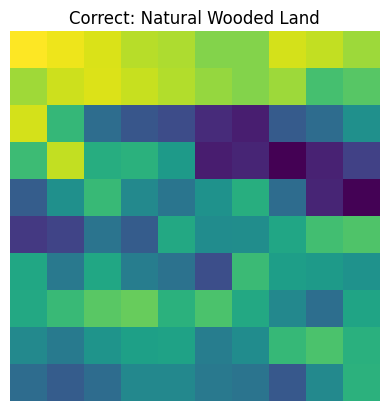

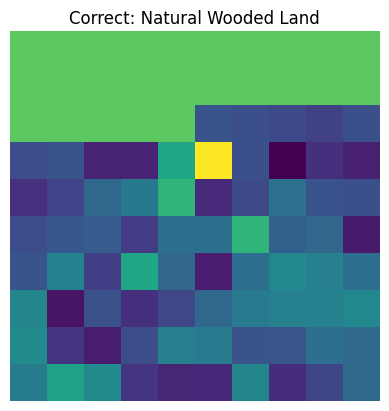

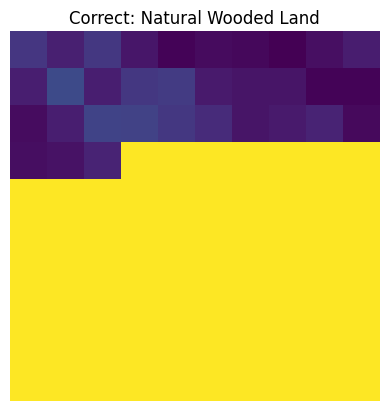

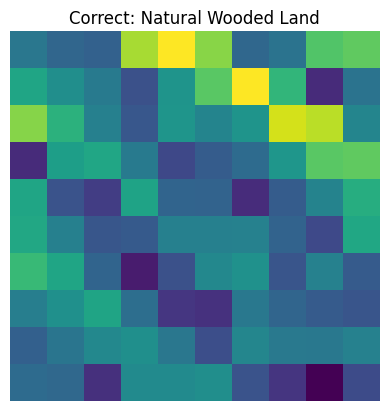

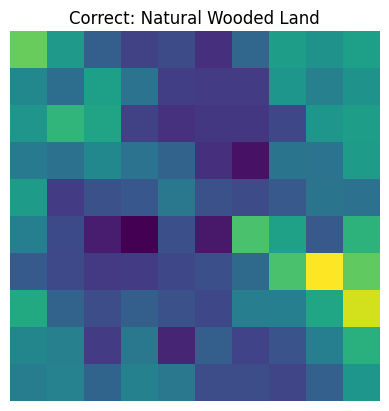

Incorrectly Classified Images for Category: Natural Wooded Land


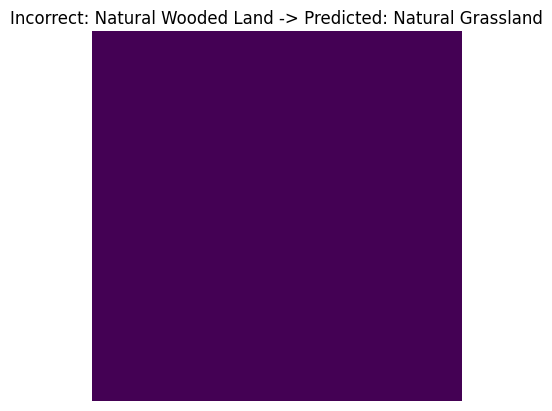

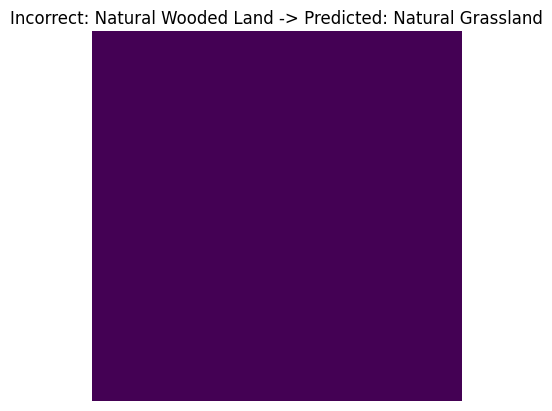

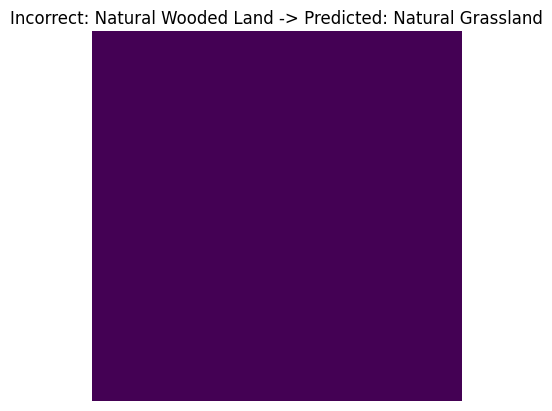

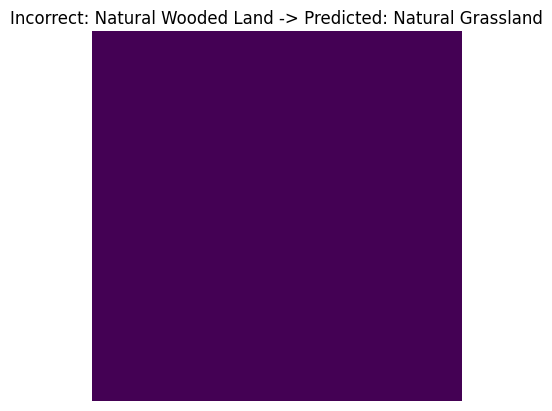

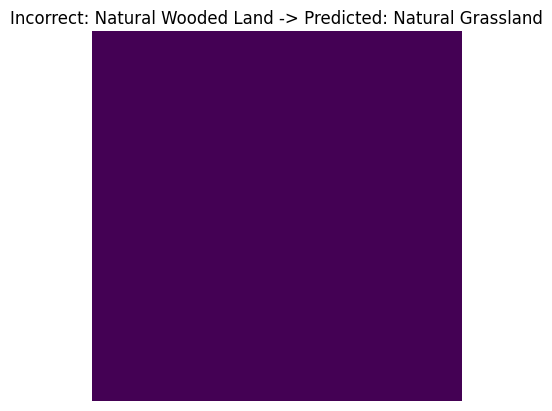

In [45]:
macro_history = macroCNN(data_with_pcs2)

In [46]:
best_val_accuracy3 = max(macro_history.history['val_accuracy'])
print(f"Best validation accuracy with principal components 2, 3, & 4: {best_val_accuracy3}")

Best validation accuracy with principal components 2, 3, & 4: 0.9382715821266174


## RGB CNN

In [47]:
def rgb_get_all_data(sample_directory_path):
    # Create the frequency labels
    columns_of_frequencies = []
    for i in range(373):  # 373 bands
        columns_of_frequencies.append(f"frq{i}")

    # Get an array of the sample file names
    filenames = get_filenames(sample_directory_path)

    # Process each file into a 3D array
    list_ds = []
    for filename in filenames:
        ds = tiff_to_arr(join(sample_directory_path, filename))  # Original dataset shape

        # Handle NaNs in the data
        ds = np.nan_to_num(ds, nan=0)  # Replace NaNs with 0 (or use `nan=np.nanmean(ds)` for mean replacement)

        # Resize if not 10x10
        if ds.shape[1:] != (10, 10):
            print(f"Resizing dataset {filename} from shape {ds.shape[1:]} to (10, 10)")
            ds = np.array([resize(band, (10, 10), mode='constant', anti_aliasing=True) for band in ds])

        list_ds.append(ds)

    # Stack all datasets into a single array (num_samples, bands, 10, 10)
    all_data = np.stack(list_ds, axis=0)  # Shape: (num_samples, bands, 10, 10)

    return all_data

In [48]:
# Load 3D data
all_data = rgb_get_all_data(path_samples)  # Shape: (num_samples, bands, 10, 10)

# Select RGB channels by indices (frq57, frq35, frq21 correspond to indices 57, 35, 21)
rgb_data = all_data[:, [57, 35, 21], :, :]  # Shape: (num_samples, ndim, height, width) (num_samples, 3, 10, 10)

# Rearrange dimensions to match CNN input expectations (num_samples, height, width, ndim)
rgb_data = np.transpose(rgb_data, (0, 2, 3, 1))  # Shape becomes (num_samples, 10, 10, 3)

Resizing dataset 2_ang20231028t100428_001_L2A_OE_main_27577724_RFL_ORT.tif from shape (11, 11) to (10, 10)
Resizing dataset 3_ang20231028t100428_000_L2A_OE_main_27577724_RFL_ORT.tif from shape (11, 11) to (10, 10)
Resizing dataset 3_ang20231028t095542_011_L2A_OE_main_27577724_RFL_ORT.tif from shape (11, 10) to (10, 10)
Resizing dataset 3_ang20231028t100428_001_L2A_OE_main_27577724_RFL_ORT.tif from shape (11, 11) to (10, 10)
Resizing dataset 4_ang20231028t101421_009_L2A_OE_main_27577724_RFL_ORT.tif from shape (11, 10) to (10, 10)
Resizing dataset 5_ang20231028t101421_009_L2A_OE_main_27577724_RFL_ORT.tif from shape (11, 10) to (10, 10)
Resizing dataset 6_ang20231028t101421_010_L2A_OE_main_27577724_RFL_ORT.tif from shape (10, 11) to (10, 10)
Resizing dataset 6_ang20231028t102348_005_L2A_OE_main_27577724_RFL_ORT.tif from shape (12, 12) to (10, 10)
Resizing dataset 7_ang20231028t102348_005_L2A_OE_main_27577724_RFL_ORT.tif from shape (12, 11) to (10, 10)
Resizing dataset 7_ang20231028t101421

In [49]:
# Encode string labels into integers
y = LabelEncoder().fit_transform(string_labels)

# Ensure alignment of data and labels
num_samples = min(rgb_data.shape[0], len(y))
rgb_data = rgb_data[:num_samples]
y = y[:num_samples]

# Step 1: Proceed with train-test split
X_train, X_test, y_train, y_test = train_test_split(rgb_data, y, test_size=0.2, random_state=42, stratify=y)

In [50]:
# Step 2: Define a simple CNN
model1 = models.Sequential([
    layers.Input(shape=(10, 10, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(12, activation='softmax')  # 12 classes
])

# Compile the model
model1.compile(optimizer=Adam(learning_rate=0.0005),
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

# Define ModelCheckpoint to save the best model based on validation accuracy
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Step 3: Train the model
kf = StratifiedKFold(n_splits=5)
for train_idx, val_idx in kf.split(rgb_data, y):
    X_train, X_val = rgb_data[train_idx], rgb_data[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    history = model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=75, callbacks=[checkpoint])

# Load the best saved model
best_model = load_model('best_model.keras')

# Step 3: Use the best model to predict
print("\n")
predictions = best_model.predict(X_test)
print(f"Predictions: {np.argmax(predictions, axis=1)[:10]}")

Epoch 1/75
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1858 - loss: 2.7051 
Epoch 1: val_accuracy improved from -inf to 0.13580, saving model to best_model.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1865 - loss: 2.7010 - val_accuracy: 0.1358 - val_loss: 2.4293
Epoch 2/75
21/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2584 - loss: 2.2333 
Epoch 2: val_accuracy improved from 0.13580 to 0.16975, saving model to best_model.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2783 - loss: 2.1849 - val_accuracy: 0.1698 - val_loss: 2.3517
Epoch 3/75
21/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3190 - loss: 2.0109 
Epoch 3: val_accuracy did not improve from 0.16975
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3137 - loss: 2.0171 - val_accuracy: 0.1420 - val_loss: 2.2892
Epoch 4/75
26/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2971 - loss: 1.9951
Epoch 4: val_accuracy did not improve from 0.16975
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step


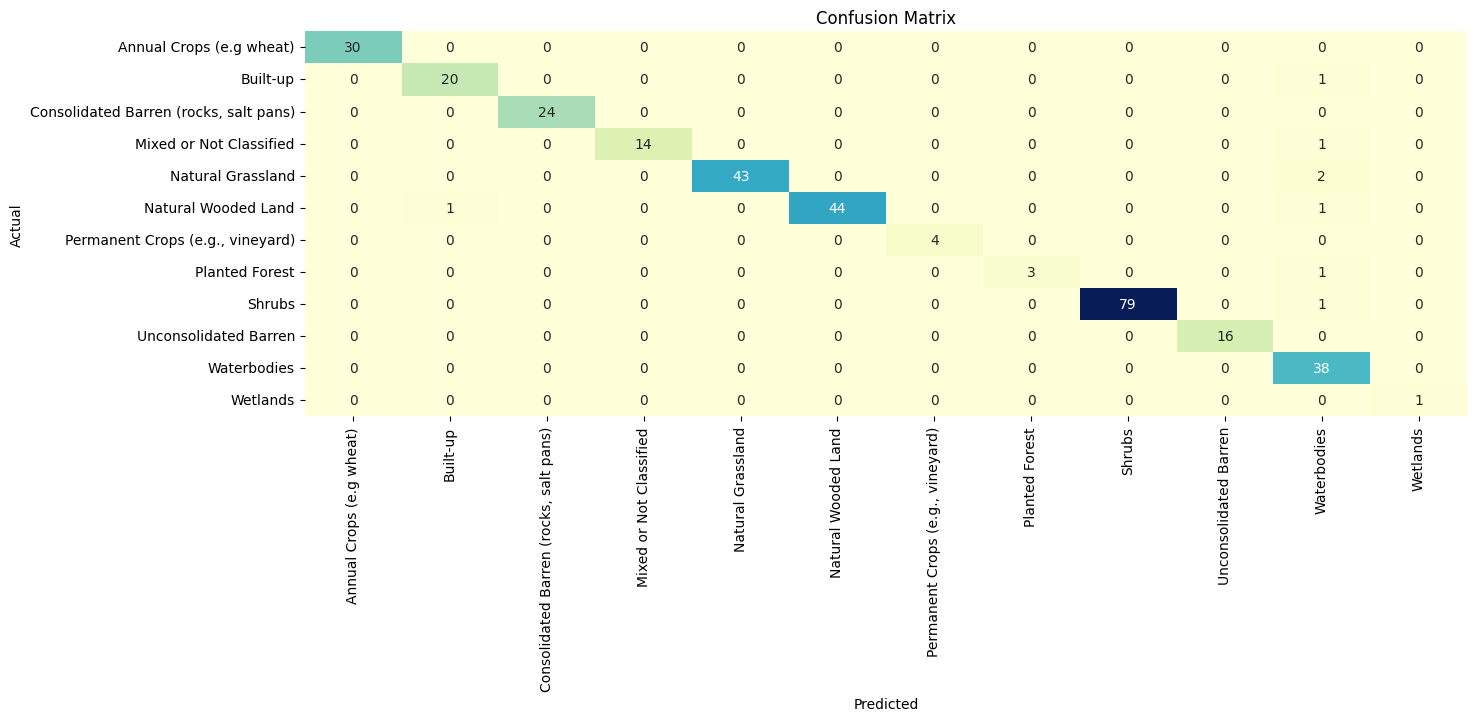

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step - accuracy: 0.9810 - loss: 0.0523
Test Accuracy: 0.9753086566925049


In [51]:
class_names = label_encoder.classes_
confMat(best_model, X_test, y_test, class_names)
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
Correctly Classified Images for Category: Shrubs


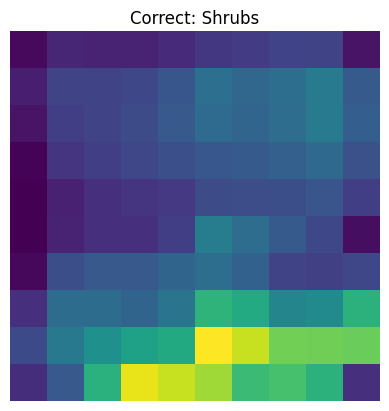

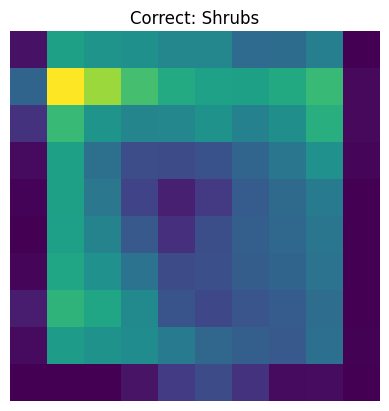

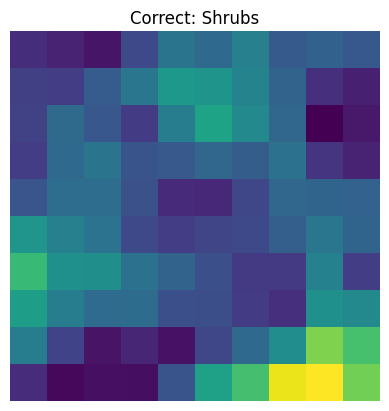

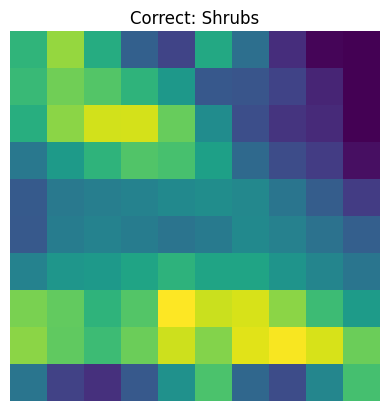

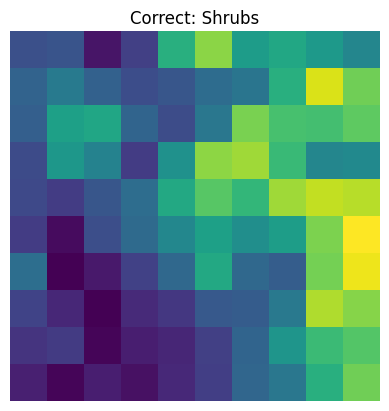

Incorrectly Classified Images for Category: Shrubs


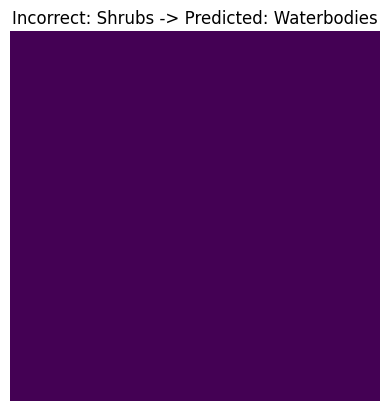

In [52]:
visualize_classification_results(
    model=best_model,                 # Your trained model
    X_test=X_test,               # Test images
    y_test=y_test,               # Ground truth labels
    label_encoder=label_encoder, # LabelEncoder instance
    category="Shrubs",  # Category to visualize
    num_samples=5                # Number of images to show
)

# FineCNN

In [53]:
def hyperspectral_cnn(input_shape, num_classes):
    """
    Create a 2D CNN model for hyperspectral image classifacation with reduced overfitting.
    """
    model = models.Sequential([
        # First Convolutional Block
        layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Conv2D(16, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        # Second Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

         # Third Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        # Fourth Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),

        # Dense Layer
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        # Output Layer
        layers.Dense(num_classes, activation='softmax')
    ])

    # Compile model
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [54]:
def new_hyperspectral_cnn(input_shape, num_classes):
    """
    Create a 2D CNN model optimized for small spatial dimensions (e.g., 10x10).
    Handles hyperspectral image classification with reduced spatial pooling.
    """
    model = models.Sequential([
        # First Convolutional Block
        layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Conv2D(16, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2), padding='same'),  # Spatial dims: 10x10 -> 5x5
        layers.Dropout(0.3),

        # Second Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2), padding='same'),  # Spatial dims: 5x5 -> 3x3
        layers.Dropout(0.3),

        # Third Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        # Replace MaxPooling with GlobalAveragePooling to handle small dimensions
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.4),

        # Dense Layer
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        # Output Layer
        layers.Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [55]:
def get_images_and_labels_tifffile(image_folder, labels_file):
    """
    Reads TIFF images and their corresponding labels from a folder and CSV file.
    Skips images without corresponding labels in the CSV file.

    Parameters:
    - image_folder: str, path to the folder containing the images.
    - labels_file: str, path to the CSV file containing the labels.

    Returns:
    - X: List of image data as NumPy arrays.
    - y: List of corresponding labels.
    """
    # Read the labels CSV
    labels_df = pd.read_csv(labels_file)

    # Create a dictionary mapping Sample_num to Class
    labels_dict = dict(zip(labels_df['Sample_num'].astype(str), labels_df['Class']))

    X = []
    y = []

    # Get all TIFF image files
    image_files = [f for f in os.listdir(image_folder) if f.endswith('.tif')]

    for image_file in image_files:
        # Extract the sample number from the filename
        sample_num = image_file.split('_')[0]

        # Skip images without labels
        if sample_num not in labels_dict:
            print(f"No label found for image: {image_file}. Skipping.")
            continue

        image_path = os.path.join(image_folder, image_file)

        try:
            # Read the TIFF image using tifffile
            image = imread(image_path)

            # Normalize image values to [0, 1]
            image = image.astype(np.float32) / 255.0

            # Append the image and its label to the lists
            X.append(image)
            y.append(labels_dict[sample_num])
        except Exception as e:
            print(f"Error reading {image_file}: {e}")

    return X, y

In [56]:
def get_images_and_labels_rasterio(image_folder, labels_file):
    """
    Reads TIFF images using rasterio and their corresponding labels from a folder and CSV file.
    Skips images without corresponding labels in the CSV file.

    Parameters:
    - image_folder: str, path to the folder containing the images.
    - labels_file: str, path to the CSV file containing the labels.

    Returns:
    - X: List of image data as NumPy arrays.
    - y: List of corresponding labels.
    """
    # Read the labels CSV
    labels_df = pd.read_csv(labels_file)

    # Create a dictionary mapping Sample_num to Class
    labels_dict = dict(zip(labels_df['Sample_num'].astype(str), labels_df['Class']))

    X = []
    y = []

    # Get all TIFF image files
    image_files = [f for f in os.listdir(image_folder) if f.endswith('.tif')]

    for image_file in image_files:
        # Extract the sample number from the filename
        sample_num = image_file.split('_')[0]

        # Skip images without labels
        if sample_num not in labels_dict:
            print(f"No label found for image: {image_file}. Skipping.")
            continue

        image_path = os.path.join(image_folder, image_file)

        try:
            # Read the TIFF image using rasterio
            with rasterio.open(image_path) as src:
                image = src.read()  # Read the image as a NumPy array (bands x rows x cols)

            # Normalize image values to [0, 1]
            image = image.astype(np.float32) / np.iinfo(src.dtypes[0]).max  # Normalize by the max possible value

            # Append the image and its label to the lists
            X.append(image)
            y.append(labels_dict[sample_num])
        except Exception as e:
            print(f"Error reading {image_file}: {e}")

    return X, y

In [57]:
def process_labels_and_save(csv_file_path, labels_to_remove):
    """
    Processes the class labels in a CSV file:
    - Converts all class labels to lowercase for consistency.
    - Removes rows with specific labels and rows with NaN values.
    - Saves a new CSV file in the same directory as the original file.

    Parameters:
    - csv_file_path: str, path to the CSV file.
    - labels_to_remove: list, class labels to remove (not case-sensitive).

    Returns:
    - processed_df: pandas DataFrame with updated labels.
    - new_file_path: str, path to the saved new CSV file.
    """
    # Load the CSV file into a DataFrame
    df = pd.read_csv(csv_file_path)

    # Ensure the 'Class' column exists
    if 'Class' not in df.columns:
        raise ValueError("The CSV file must have a 'Class' column.")

    # Convert all class labels to lowercase
    df['Class'] = df['Class'].str.lower()

    # Remove rows with NaN values in the 'Class' column
    df = df.dropna(subset=['Class'])

    # Remove rows with labels to remove (case-insensitive)
    labels_to_remove_lower = [label.lower() for label in labels_to_remove]
    df = df[~df['Class'].isin(labels_to_remove_lower)]

    # Save the processed DataFrame to a new CSV file in the same directory
    base_dir = os.path.dirname(csv_file_path)
    new_file_name = "Processed_" + os.path.basename(csv_file_path)
    new_file_path = os.path.join(base_dir, new_file_name)
    df.to_csv(new_file_path, index=False)

    return df, new_file_path

In [58]:
def augment_images(X, y):
    """
    Augments images stored as NumPy arrays and updates labels accordingly.

    Parameters:
    - X: List of original images as NumPy arrays.
    - y: List of original labels.

    Returns:
    - X_augmented: List of original and augmented images as NumPy arrays.
    - y_augmented: List of labels corresponding to X_augmented.
    """
    X_augmented = X.copy()
    y_augmented = y.copy()

    for i in range(len(X)):
        image = X[i]
        label = y[i]

        # Flip vertically
        flipped_vert = np.flipud(image)
        X_augmented.append(flipped_vert)
        y_augmented.append(label)

        # Flip horizontally
        flipped_horiz = np.fliplr(image)
        X_augmented.append(flipped_horiz)
        y_augmented.append(label)

        # Rotate 90 degrees clockwise
        rotated = np.rot90(image, k=-1)
        X_augmented.append(rotated)
        y_augmented.append(label)

        rotated_counterclockwise = np.rot90(image, k=1)
        X_augmented.append(rotated_counterclockwise)
        y_augmented.append(label)

    return X_augmented, y_augmented

In [59]:
def prepare_data_for_training(X, y, test_size=0.2, random_state=42):
    """
    Prepares data for training by resizing and normalizing images and splitting into train/test sets.

    Parameters:
    - X: List of images as NumPy arrays.
    - y: List of labels.
    - test_size: Fraction of the dataset to reserve for testing.
    - random_state: Seed for random number generator.

    Returns:
    - X_train: Training images as NumPy arrays.
    - X_test: Testing images as NumPy arrays.
    - y_train: Training labels.
    - y_test: Testing labels.
    """


    # Define target image size
    target_size = (10,10)

    # Initialize lists to hold resized image arrays
    X_resized = []

    for img in X:
        # Resize image using OpenCV
        resized_img = cv2.resize(img, target_size, interpolation=cv2.INTER_LINEAR)
        X_resized.append(resized_img)

    # Normalize pixel values to [0, 1]
    X_resized = np.array(X_resized).astype(np.float32) / 255.0
    y_array = np.array(y)

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X_resized, y_array,
        test_size=test_size,
        random_state=random_state,
        stratify=y_array
    )

    return X_train, X_test, y_train, y_test

In [60]:
def clean_data(X, y, target_shape=(10, 10)):
    """
    Cleans and preprocesses the data:
    - Removes invalid samples (nan or inf values in X).
    - Resizes images to the target shape.

    Parameters:
    - X: list of image data (e.g., NumPy arrays of varying shapes).
    - y: list of corresponding labels.
    - target_shape: tuple, desired (height, width) for resizing images.

    Returns:
    - X_cleaned: numpy.ndarray, cleaned and resized input data.
    - y_cleaned: numpy.ndarray, cleaned labels.
    """
    X_cleaned = []
    y_cleaned = []

    for i, img in enumerate(X):
        # Check for valid images (no nan or inf values)
        if img is not None and not np.isnan(img).any() and not np.isinf(img).any():
            try:
                # Resize image to target shape while preserving channels
                current_shape = img.shape
                if current_shape[:2] != target_shape:
                    zoom_factors = (target_shape[0] / current_shape[0],
                                    target_shape[1] / current_shape[1],
                                    1)  # Keep channels unchanged
                    img = zoom(img, zoom_factors, order=1)  # Bilinear interpolation

                # Append the resized and valid image
                X_cleaned.append(img)
                y_cleaned.append(y[i])
            except AttributeError:
                print(f"Image {i} is not a valid NumPy array. Skipping.")
        else:
            print(f"Image {i} contains invalid values (nan or inf). Skipping.")

    return np.array(X_cleaned), np.array(y_cleaned)

In [61]:
def plot_training_history(history, cnn_model, X_test, y_test):
    """
    Plots the training and validation accuracy and loss from the history object.
    """
    plt.figure(figsize=(14, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid()

    plt.tight_layout()

    y_pred = cnn_model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_classes)

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=range(12))
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

In [62]:
def plot_class_distribution(y, class_names, title="Class Distribution"):
    """
    Plots a histogram showing the distribution of samples across classes.

    Parameters:
    - y: array-like, labels for the dataset (as strings or integers).
    - class_names: list, names of the classes corresponding to the labels.
    - title: str, title for the plot.

    Returns:
    - None
    """
    # Count occurrences of each class
    class_counts = Counter(y)

    # Ensure the order of bars matches class_names
    counts = [class_counts.get(cls, 0) for cls in class_names]

    # Create a bar plot
    plt.figure(figsize=(10, 6))  # Adjust figure size as needed
    plt.bar(class_names, counts)
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.title(title)
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.grid(axis='y')
    plt.tight_layout()  # Adjust layout to prevent label cutoff
    plt.show()

In [63]:
def get_class_counts(y, class_names=None):
    """
    Returns the count of samples for each class in the dataset.

    Parameters:
    - y: array-like, labels for the dataset (as strings or integers).
    - class_names: list, optional, names of the classes corresponding to the labels.

    Returns:
    - class_counts: dict, mapping of class names (or labels) to their counts.
    """
    # Count occurrences of each class
    class_counts = Counter(y)

    # Map counts to class names if provided
    if class_names is not None:
        class_counts = {class_names[int(label)]: count for label, count in class_counts.items()}

    return class_counts

In [64]:
"""Add class weights to help with data imbalance"""
def calculate_class_weights(class_counts):
    """
    Calculates class weights to handle class imbalance.

    Parameters:
    - class_counts: dict, mapping of class names or indices to their counts.

    Returns:
    - class_weights: dict, mapping of class indices to weights.
    """
    total_samples = sum(class_counts.values())
    num_classes = len(class_counts)

    # Ensure class indices are numeric
    class_weights = {
        idx: total_samples / (num_classes * count)
        for idx, count in enumerate(class_counts.values())
    }

    return class_weights

In [65]:
imageFolderPath = 'Data/Images'
labelsFilePath = 'Data/ConsolidatedLabels.csv'

df, new_file_path = process_labels_and_save(labelsFilePath, ['nan', 'Tie', '#N/A'])

# rasterio_X, rasterio_y = get_images_and_labels_rasterio(imageFolderPath, new_file_path)
tifffile_X, tifffile_y = get_images_and_labels_tifffile(imageFolderPath, new_file_path)

# cleaned_tifffile_X, cleaned_tifffile_y = clean_data(tifffile_X, tifffile_y)

# new_rasterio_X, new_rasterio_y = augment_images(rasterio_X, rasterio_y)
new_tifffile_X, new_tifffile_y = augment_images(tifffile_X, tifffile_y)

# print(f"Original data: {len(rasterio_X)} images, {len(rasterio_y)} labels")
# print(f"Augmented data: {len(new_rasterio_X)} images, {len(new_rasterio_y)} labels")

print(f"Original data: {len(tifffile_X)} images, {len(tifffile_y)} labels")

print(f"Augmented data: {len(new_tifffile_X)} images, {len(new_tifffile_y)} labels")

No label found for image: 7310_ang20231025t060824_009_L2A_OE_main_27577724_RFL_ORT.tif. Skipping.
No label found for image: 6116_ang20231109t101807_036_L2A_OE_main_27577724_RFL_ORT.tif. Skipping.
No label found for image: 5509_ang20231110t094423_004_L2A_OE_main_27577724_RFL_ORT.tif. Skipping.
No label found for image: 8251_ang20231109t133124_008_L2A_OE_main_27577724_RFL_ORT.tif. Skipping.
No label found for image: 8248_ang20231109t133124_009_L2A_OE_main_27577724_RFL_ORT.tif. Skipping.
No label found for image: 7883_ang20231126t094733_013_L2A_OE_main_27577724_RFL_ORT.tif. Skipping.
No label found for image: 9610_ang20231113t131251_016_L2A_OE_main_27577724_RFL_ORT.tif. Skipping.
No label found for image: 8155_ang20231109t133124_010_L2A_OE_main_27577724_RFL_ORT.tif. Skipping.
No label found for image: 7883_ang20231113t132348_012_L2A_OE_main_27577724_RFL_ORT.tif. Skipping.
No label found for image: 7649_ang20231109t092617_045_L2A_OE_main_27577724_RFL_ORT.tif. Skipping.
No label found for i

In [66]:
cleaned_tifffile_X, cleaned_tifffile_y = clean_data(new_tifffile_X, new_tifffile_y, (10, 10))
print(f"Cleaned data: {len(cleaned_tifffile_X)} images, {len(cleaned_tifffile_y)} labels")

X_train, X_test, y_train, y_test = prepare_data_for_training(cleaned_tifffile_X, cleaned_tifffile_y)

cnn_model = hyperspectral_cnn(input_shape=(dataset_1.height, dataset_1.width, dataset_1.count), num_classes=12)


Image 2 contains invalid values (nan or inf). Skipping.
Image 15 contains invalid values (nan or inf). Skipping.
Image 34 contains invalid values (nan or inf). Skipping.
Image 42 contains invalid values (nan or inf). Skipping.
Image 43 contains invalid values (nan or inf). Skipping.
Image 50 contains invalid values (nan or inf). Skipping.
Image 58 contains invalid values (nan or inf). Skipping.
Image 94 contains invalid values (nan or inf). Skipping.
Image 110 contains invalid values (nan or inf). Skipping.
Image 112 contains invalid values (nan or inf). Skipping.
Image 116 contains invalid values (nan or inf). Skipping.
Image 122 contains invalid values (nan or inf). Skipping.
Image 124 contains invalid values (nan or inf). Skipping.
Image 127 contains invalid values (nan or inf). Skipping.
Image 145 contains invalid values (nan or inf). Skipping.
Image 155 contains invalid values (nan or inf). Skipping.
Image 161 contains invalid values (nan or inf). Skipping.
Image 173 contains inva

KeyboardInterrupt: 

In [ ]:
# Create a mapping from label strings to integers
unique_labels = sorted(set(y_train))
label_to_int = {label: idx for idx, label in enumerate(unique_labels)}

print(f"Label to integer mapping: {label_to_int}")
print(f"Unique labels: {unique_labels}")
print("unique labels:",set(unique_labels))
print("unique labels:",len(set(unique_labels)))

# Convert y_train and y_test to integers
y_train = [label_to_int[label] for label in y_train]
y_test = [label_to_int[label] for label in y_test]

In [ ]:
# Print shapes to check compatibility
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Model input shape:", cnn_model.input_shape)

# Print data types to ensure consistency
print("X_train dtype:", X_train.dtype)
print("X_test dtype:", X_test.dtype)
print("y_train dtype:", type(y_train))
print("y_test dtype:", type(y_test))

# Convert y_train and y_test to NumPy arrays with integer type
y_train = np.array(y_train, dtype=np.int32)
y_test = np.array(y_test, dtype=np.int32)

# Verify the conversion
print("y_train dtype:", y_train.dtype)
print("y_train shape:", y_train.shape)
print("y_test dtype:", y_test.dtype)
print("y_test shape:", y_test.shape)

# Convert X_train and X_test to NumPy arrays with float32 type
X_train = np.array(X_train, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)

# Verify the conversion
print("X_train dtype:", X_train.dtype)
print("X_test dtype:", X_test.dtype)

In [ ]:
# Check unique labels and their range

# print("X_train range:", X_train.min(), X_train.max())

# print("Unique labels in y_train:", np.unique(y_train))
# print("Unique labels in y_test:", np.unique(y_test))

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-6)


history = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler]
)

In [ ]:
plot_training_history(history, cnn_model, X_test, y_test)

In [ ]:
# Plot accuracy vs val_accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot loss vs val_loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Validation Loss')
plt.legend()
plt.grid()
plt.show()


# Get predicted labels
y_pred = cnn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=range(12))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Get the highest validation accuracy and corresponding epoch
best_val_accuracy = max(history.history['val_accuracy'])
best_epoch = history.history['val_accuracy'].index(best_val_accuracy) + 1

print(f"Highest Validation Accuracy: {best_val_accuracy:.4f}")
print(f"Epoch with Highest Validation Accuracy: {best_epoch}")

# Get predicted probabilities
y_pred = cnn_model.predict(X_test)

# Convert to percentages
y_pred_percentages = y_pred * 100

for i in range(best_epoch):
    print(f"Sample {i}:")
    for cls, prob in enumerate(y_pred_percentages[i]):
        print(f"  Class {cls}: {prob:.2f}%")

In [ ]:
# Assuming y_train and y_test are NumPy arrays or lists of numeric or string labels
combined_labels = np.concatenate((y_train, y_test))  # Combine datasets if needed
combined_labels = [str(label) for label in combined_labels]  # Convert to strings if necessary

# Define class names (if numeric labels are used)
class_names = sorted(set(combined_labels))  # Replace with your actual class names if needed

# Get class counts
class_counts = get_class_counts(combined_labels)

# Print class counts
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

# Plot the class distribution
plot_class_distribution(combined_labels, class_names, title="Class Distribution for Entire Dataset")

In [ ]:


# Example usage
# Combine training and testing labels
combined_labels = np.concatenate((y_train, y_test))  # Ensure y_train and y_test are NumPy arrays
combined_labels = [str(label) for label in combined_labels]  # Convert labels to strings if needed

# Dynamically get class counts
class_counts = get_class_counts(combined_labels)

# Calculate class weights
class_weights = calculate_class_weights(class_counts)

# Print class weights for verification
print("Class Weights:")
for idx, (class_name, weight) in enumerate(zip(class_counts.keys(), class_weights.values())):
    print(f"Class {idx} ('{class_name}') weight: {weight:.4f}")

In [ ]:
# Calculate class weights
class_weights = calculate_class_weights(class_counts)

cnn_model_2 = hyperspectral_cnn(input_shape=(10, 10, 373), num_classes=12)

# Train the model with class weights
history_2 = cnn_model_2.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stopping, lr_scheduler]
)

In [ ]:
# Plot accuracy vs val_accuracy
plt.plot(history_2.history['accuracy'], label='Training Accuracy')
plt.plot(history_2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot loss vs val_loss
plt.plot(history_2.history['loss'], label='Training Loss')
plt.plot(history_2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Validation Loss')
plt.legend()
plt.grid()
plt.show()

# # Get predicted labels
# y_pred_2 = cnn_model_2.predict(X_test)
# y_pred_classes_2 = np.argmax(y_pred_2, axis=1)

# # Compute confusion matrix
# conf_matrix_2 = confusion_matrix(y_test, y_pred_classes_2)

# # Display the confusion matrix
# disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_2, display_labels=range(12))
# plt.title('Confusion Matrix')
# plt.show()


# Get predicted labels
y_pred_2 = cnn_model_2.predict(X_test)
y_pred_classes_2 = np.argmax(y_pred_2, axis=1)

# Compute confusion matrix
conf_matrix_2 = confusion_matrix(y_test, y_pred_classes_2)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_2, display_labels=range(12))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Get the highest validation accuracy and corresponding epoch
best_val_accuracy_2 = max(history_2.history['val_accuracy'])
best_epoch_2 = history_2.history['val_accuracy'].index(best_val_accuracy_2) + 1

print(f"Highest Validation Accuracy: {best_val_accuracy_2:.4f}")
print(f"Epoch with Highest Validation Accuracy: {best_epoch_2}")

# Get predicted probabilities
y_pred_2 = cnn_model_2.predict(X_test)

# Convert to percentages
y_pred_percentages_2 = y_pred_2 * 100

for i in range(best_epoch_2):
    print(f"Sample {i}:")
    for cls, prob in enumerate(y_pred_percentages_2[i]):
        print(f"  Class {cls}: {prob:.2f}%")